# Классификация музыкальных произведений по жанрам для музыкального стримингового сервиса «МиФаСоль»

Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача: правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Для выполнения проекта отдел работы со звуком подготовил датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры.

**Цель проекта**: 
* Разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

**Предоставленные данные**:
* `train.csv` - информация (40000) музыкальных треках, которые будут использоваться в качестве обучающих данных;
* `test.csv` - информация (10000) музыкальных треках, которые будут использоваться в качестве тестовых данных.

## Импорт библиотек

In [ ]:
%pip install phik -q
%pip install shap -q

In [104]:
import pandas  as pd
import seaborn as sb
import numpy   as np

import phik
import shap

import matplotlib.pyplot     as plt

from sklearn                 import tree as tree
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import OneHotEncoder
from sklearn.dummy           import DummyRegressor
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.ensemble        import HistGradientBoostingClassifier
from sklearn.ensemble        import HistGradientBoostingRegressor
from sklearn.ensemble        import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model    import LinearRegression

pd.set_option("display.max_columns", 500)          # show all cols
pd.set_option('max_colwidth', None)                # show full width of showing cols
pd.set_option("expand_frame_repr", False)          # print cols side by side as it's supposed to be
pd.options.display.float_format = '{:,.2f}'.format # pretty format for floats
pd.options.mode.chained_assignment = None          # ignore SettingWithCopy warning

sb.set(font_scale=0.8)                             # default font size on heatmaps was too big

## Загрузка данных

### Чтение данных

In [105]:
try:
    df_test  = pd.read_csv('data/test.csv', sep=',')
    df_train = pd.read_csv('data/train.csv', sep=',')
    print('Данные загружены из локальной папки.')
except:
    raise Exception('Датасеты не найдены.')

Данные загружены из локальной папки.


### Общая информация о представленном датасете

In [106]:
def show_info(data: pd.DataFrame, full: bool=True, name: str=''):
    if name != '':
        border_len = len('Имя датасета: ' + name) + 2
        print ('\n╔' + '═' * border_len + '╗')
        print (f'║ Имя датасета: {name} ║')
        print ('╚' + '═' * border_len + '╝\n')
    
    print('Первые пять строк:')
    display(data.head(5))
    print('Информация по столбцам:')
    data.info()
    print("\nЧисло явных дубликатов:", data.duplicated().sum())
    print("Число пропусков:", data.isna().sum().sum())

In [107]:
show_info(df_train,name='train.csv')
show_info(df_test,name='test.csv')


╔═════════════════════════╗
║ Имя датасета: train.csv ║
╚═════════════════════════╝

Первые пять строк:


,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,4919,By Your Side,33.00,0.00,0.50,-1.00,0.94,0.02,G#,0.08,-5.57,Minor,0.16,144.922,4-Apr,0.19,Electronic
1,16096,NaN,55.00,0.06,0.28,"288,333.00",0.74,0.01,C,0.29,-5.57,Major,0.03,126.914,NaN,0.21,Alternative
2,43825,Symphony No. 6: VI. Allegro,39.00,0.93,0.36,"115,240.00",0.35,0.94,NaN,0.11,-13.28,NaN,0.03,65.42699999999999,4-Apr,0.09,Classical
3,4331,NaN,56.00,0.01,0.33,"234,638.00",0.85,0.00,B,0.30,-4.51,Minor,0.09,67.23,5-Apr,0.39,Electronic
4,21371,Shoe Shopping,52.00,0.58,0.72,"221,640.00",0.61,0.00,G,0.16,-7.10,Major,0.04,88.006,4-Apr,0.68,Country


Информация по столбцам:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       40000 non-null  int64  
 1   track_name        29262 non-null  object 
 2   popularity        36078 non-null  float64
 3   acousticness      40000 non-null  float64
 4   danceability      37963 non-null  float64
 5   duration_ms       40000 non-null  float64
 6   energy            40000 non-null  float64
 7   instrumentalness  40000 non-null  float64
 8   key               38577 non-null  object 
 9   liveness          40000 non-null  float64
 10  loudness          40000 non-null  float64
 11  mode              38147 non-null  object 
 12  speechiness       40000 non-null  float64
 13  tempo             40000 non-null  object 
 14  obtained_date     33781 non-null  object 
 15  valence           40000 non-null  float64
 16  music_genre     

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,20514,Bullet Proof ... I Wish I Was,49.00,0.78,0.45,"208,733.00",0.36,0.67,G,0.08,-13.56,Major,0.03,80.91199999999999,4-Apr,0.08
1,46957,Does It,48.00,0.21,0.65,"262,547.00",0.66,0.00,A,0.21,-9.43,NaN,0.17,120.10799999999999,4-Apr,0.27
2,5488,NaN,34.00,0.16,0.59,"270,733.00",0.28,0.68,C#,0.13,-14.14,Major,0.04,153.464,3-Apr,0.14
3,18150,Breaking Inside (feat. Lzzy Hale of Halestorm),41.00,0.07,0.47,"227,467.00",0.91,0.00,D,0.09,-3.42,Minor,0.05,151.977,4-Apr,0.42
4,20148,NaN,47.00,0.00,0.34,"298,813.00",0.97,0.00,D,0.36,-3.22,Minor,0.06,175.02700000000002,4-Apr,0.57


Информация по столбцам:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       10000 non-null  int64  
 1   track_name        7388 non-null   object 
 2   popularity        8987 non-null   float64
 3   acousticness      10000 non-null  float64
 4   danceability      9477 non-null   float64
 5   duration_ms       10000 non-null  float64
 6   energy            10000 non-null  float64
 7   instrumentalness  10000 non-null  float64
 8   key               9673 non-null   object 
 9   liveness          10000 non-null  float64
 10  loudness          10000 non-null  float64
 11  mode              9518 non-null   object 
 12  speechiness       10000 non-null  float64
 13  tempo             10000 non-null  object 
 14  obtained_date     8419 non-null   object 
 15  valence           10000 non-null  float64
dtypes: float64(10), i

### Выводы по разделу

Для исследования предоставлены два датасета:

* `train.csv` — информация (40000) музыкальных треках, которые будут использоваться в качестве обучающих данных;
* `test.csv` — информация (10000) музыкальных треках, которые будут использоваться в качестве тестовых данных.

Описание полей данных:

* `instance_id` - уникальный идентификатор трека;
* `track_name` - название трека
* `popularity` - популярность трека;
* `acousticness` - мера уверенности от 0,0 до 1,0 в том, что трек является акустическим;
* `danceability` - танцевальность описывает, насколько трек подходит для танцев, основываясь на сочетании музыкальных элементов, включая темп, стабильность ритма, силу ударов и общую регулярность;
* `duration_ms` - продолжительность трека в миллисекундах;
* `energy` - энергия это показатель от 0,0 до 1,0, представляющий собой меру интенсивности и активности;
* `instrumentalness` - определяет, содержит ли трек вокал;
* `key` - базовый ключ произведения;
* `liveness` - определяет присутствие аудитории в записи;
* `loudness` - общая громкость трека в децибелах (дБ);
* `mode` - указывает на модальность трека;
* `speechiness` - речевой характер определяет наличие в треке разговорной речи;
* `tempo` - темп трека в ударах в минуту (BPM);
* `obtained_date` - дата загрузки в сервис;
* `valence` - показатель характеризующий музыкальный позитив, передаваемый треком;
* `music_genre` - музыкальный жанр трека, целевой признак для предсказания.

В датасетах отсутствуют явные дубликаты. Столбцы `track_name`, `popularity`, `danceability`, `key`, `mode` и `obtained_date` содержат пропуски. Столбец `tempo` должен быть представлен в числовом формате, однако в исходных данных имеет тип `object`.

## Предобработка и исследовательский анализ

### Типы данных

Столбец `tempo` должен быть представлен в числовом формате, однако в исходных данных имеет тип `object`, т.к. содержит пропуски:

In [108]:
print('Число пропусков в столбце templo в датасете train:', len(df_train.query('tempo == "?"')))
print('Число пропусков в столбце templo в датасете test:', len(df_test.query('tempo == "?"')))

Число пропусков в столбце templo в датасете train: 3979
Число пропусков в столбце templo в датасете test: 1001


Конвертируем столбец в числовой формат. Пропуски будут заполнены после анализа корреляции признаков.

In [109]:
df_train['tempo'] = pd.to_numeric(df_train['tempo'],errors='coerce')
df_test['tempo'] = pd.to_numeric(df_test['tempo'],errors='coerce')

### Признаки на основе названия трека

In [110]:
df_train['track_name'] = df_train['track_name'].fillna("")
df_test['track_name'] = df_test['track_name'].fillna("")

#### Число слов в названии трека

In [111]:
df_train['words_count'] = df_train.apply(lambda row: len(row['track_name'].split()), axis=1)
df_test['words_count'] = df_test.apply(lambda row: len(row['track_name'].split()), axis=1)

#### Длина названия трека

In [112]:
df_train['name_length'] = df_train.apply(lambda row: len(row['track_name']), axis=1)
df_test['name_length'] = df_test.apply(lambda row: len(row['track_name']), axis=1)

#### Содержание знаков препинания

In [113]:
df_train['has_exclamation'] = df_train.apply(lambda row: 1 if row['track_name'].find("!")>-1 else 0, axis=1)
df_test['has_exclamation'] = df_test.apply(lambda row: 1 if row['track_name'].find("!")>-1 else 0, axis=1)

In [114]:
df_train['has_question'] = df_train.apply(lambda row: 1 if row['track_name'].find("?")>-1 else 0, axis=1)
df_test['has_question'] = df_test.apply(lambda row: 1 if row['track_name'].find("?")>-1 else 0, axis=1)

#### Содержание специальных слов

In [115]:
special_words = ['blues','feat','symphony','sonata','piano','live','mix','remastered','remix','major','minor']

In [116]:
for word in special_words:
    df_train['has_' + word] = df_train.apply(lambda row: 1 if row['track_name'].lower().find(word)>-1 else 0, axis=1)
    df_test['has_' + word] = df_test.apply(lambda row: 1 if row['track_name'].lower().find(word)>-1 else 0, axis=1)

#### Доля гласных

In [117]:
def get_vowels_portion(string):
    if len(string) == 0:
        return -1
    vowels = "aeiouAEIOU"
    count = sum(string.count(vowel) for vowel in vowels)
    return count / len(string)

df_train['vowels'] = df_train.apply(lambda row: get_vowels_portion(row['track_name']), axis=1)
df_test['vowels'] = df_test.apply(lambda row: get_vowels_portion(row['track_name']), axis=1)

vowels_median = df_train.query('vowels > -1')['vowels'].median()
df_train.loc[df_train['vowels'] == -1,'vowels'] = vowels_median
df_test.loc[df_test['vowels'] == -1,'vowels'] = vowels_median

### Средний код символов

In [118]:
def get_char_ord_mean(string):
    if string == "":
        return 0

    ord_sum = 0
    for char in string:
        ord_sum += ord(char)
    return ord_sum / len(string)

df_train['char_ord'] = df_train.apply(lambda row: get_char_ord_mean(row['track_name']), axis=1)
df_test['char_ord']  = df_test.apply(lambda row: get_char_ord_mean(row['track_name']), axis=1)

char_ord_median = df_train.query('char_ord > 0')['char_ord'].median()
print ('char_ord_median =',char_ord_median)
df_train.loc[df_train['char_ord'] == 0,'char_ord'] = char_ord_median
df_test.loc[df_test['char_ord'] == 0,'char_ord'] = char_ord_median

char_ord_median = 90.55868852459017


### Корреляция признаков

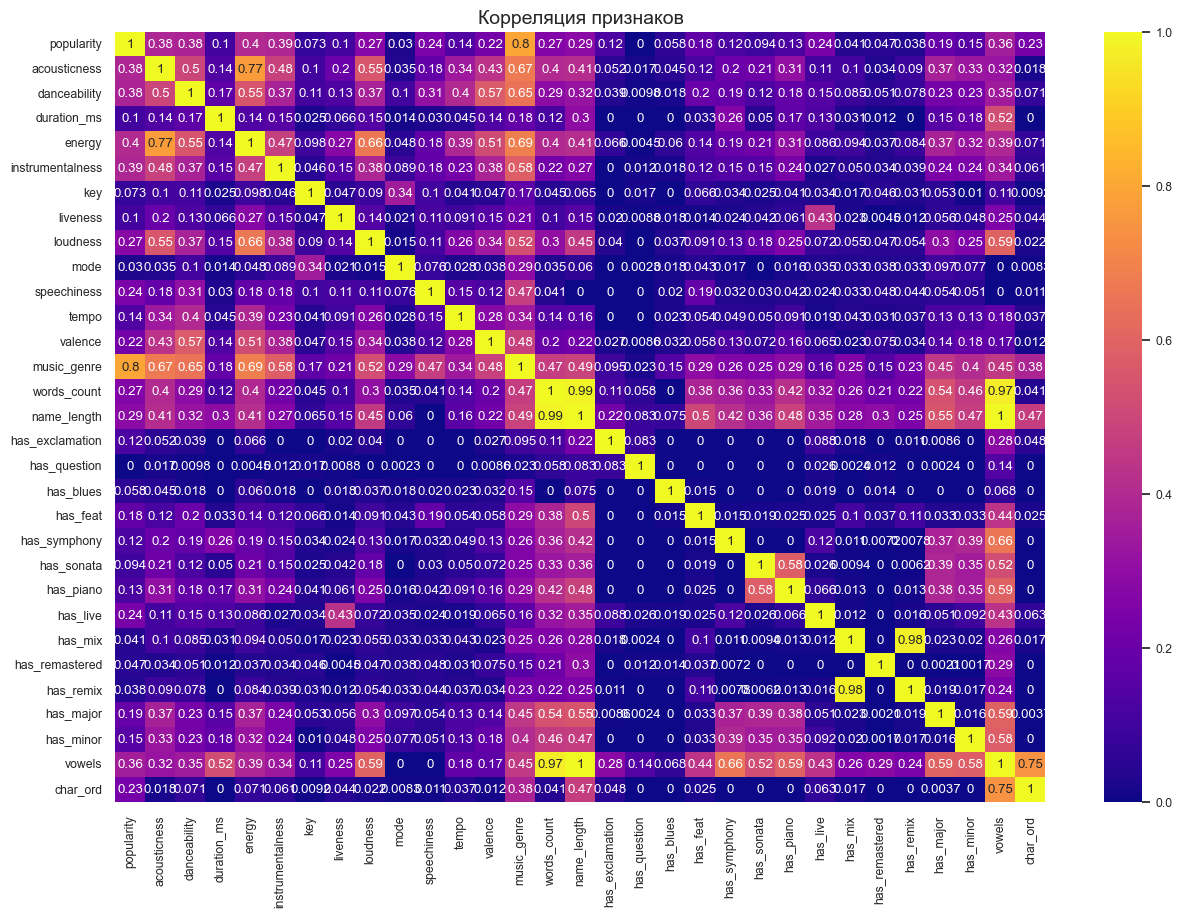

In [119]:
interval_columns = ['words_count','popularity','acousticness','danceability','duration_ms','energy','instrumentalness',
                    'liveness','loudness','speechiness','tempo','valence','char_ord','el']
corr_matrix = df_train.drop(['instance_id','track_name','obtained_date'], axis=1).phik_matrix(interval_cols=interval_columns)

plt.figure(figsize=(15, 10))
sb.heatmap(corr_matrix, annot=True, cmap='plasma')
plt.title('Корреляция признаков', fontsize=14)
plt.show()

### Столбец `danceability`

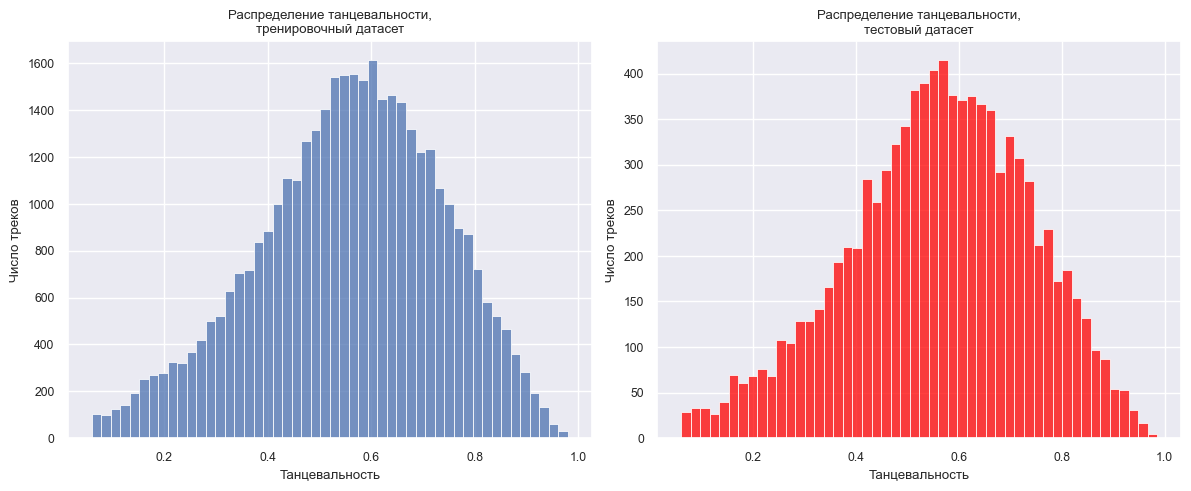

In [120]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
sb.histplot(data=df_train, x="danceability", bins=50, ax=axs[0]).set(
    xlabel='Танцевальность', ylabel='Число треков', title='Распределение танцевальности,\nтренировочный датасет')
sb.histplot(data=df_test, x="danceability", bins=50, ax=axs[1], color='red',).set(
    xlabel='Танцевальность', ylabel='Число треков', title='Распределение танцевальности,\nтестовый датасет')
plt.tight_layout() 
plt.show()

In [121]:
print(f'Число пропусков в столбце danceability в датасете train: '
      f'{df_train["danceability"].isna().sum()}, {df_train["danceability"].isna().sum()/len(df_train)*100:.1f}%')
print(f'Число пропусков в столбце danceability в датасете test: '
      f'{df_test["danceability"].isna().sum()}, {df_test["danceability"].isna().sum()/len(df_test)*100:.1f}%')

Число пропусков в столбце danceability в датасете train: 2037, 5.1%
Число пропусков в столбце danceability в датасете test: 523, 5.2%


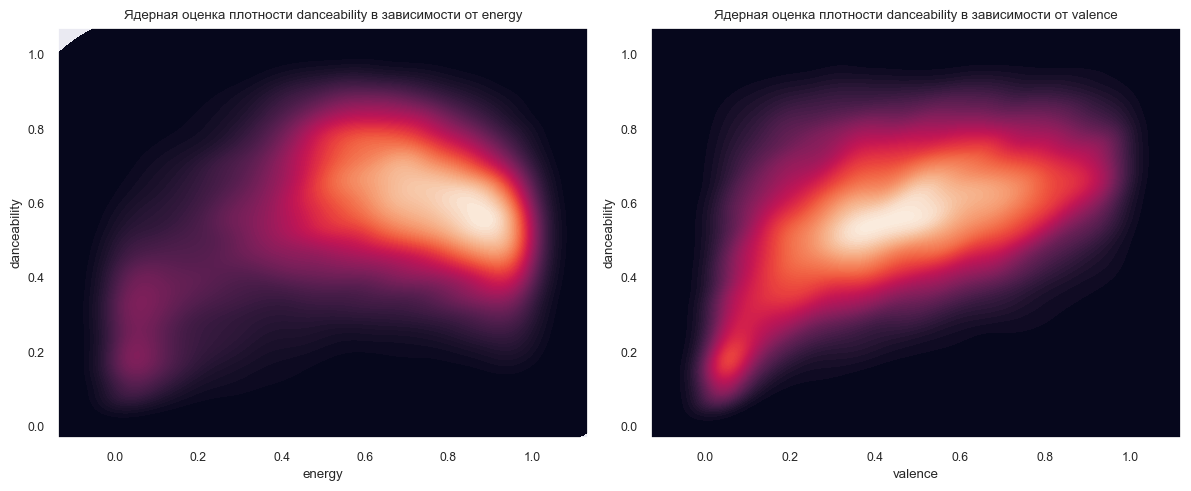

In [122]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
sb.kdeplot(data=df_train, x="energy", y="danceability", fill=True, thresh=0, levels=100, cmap="rocket", ax=axs[0]).set(
    title='Ядерная оценка плотности danceability в зависимости от energy', xlabel='energy', ylabel='danceability')
sb.kdeplot(data=df_train, x="valence", y="danceability", fill=True, thresh=0, levels=100, cmap="rocket", ax=axs[1]).set(
    title='Ядерная оценка плотности danceability в зависимости от valence', xlabel='valence', ylabel='danceability')
plt.tight_layout() 
plt.show()

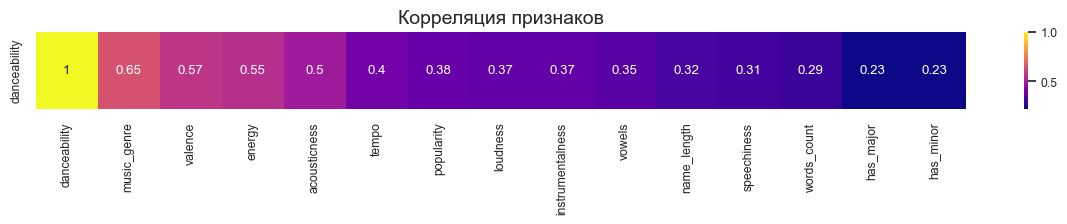

In [123]:
plt.figure(figsize=(15, 1))
sb.heatmap(corr_matrix[['danceability']].sort_values(
    by='danceability',ascending=False).head(15).T, annot=True, cmap='plasma')
plt.title('Корреляция признаков', fontsize=14)
plt.show()

Восстановим пропущенные значения `danceability`:

In [124]:
regressor_features_columns = ['energy','valence','acousticness','tempo','popularity','loudness','vowels','name_length','instrumentalness','speechiness']
regressor_target_columns   = ['danceability']
df_for_danceability_regressor = df_train.dropna(subset=['danceability','tempo','popularity'])
X = df_for_danceability_regressor[regressor_features_columns]
Y = df_for_danceability_regressor[regressor_target_columns].values.ravel()

print(cross_val_score(DummyRegressor(strategy='median'), X, Y, cv=5).mean())
print(cross_val_score(LinearRegression(), X, Y, cv=5).mean())
print(cross_val_score(HistGradientBoostingRegressor(random_state=42), X, Y, cv=5).mean())

-0.003237960352591296
0.3498160127420221
0.6169125370949858


In [125]:
danceability_regressor = HistGradientBoostingRegressor(random_state=42)
danceability_regressor.fit(X, Y)

def get_danceability(row):
    if pd.isna(row[regressor_target_columns][0]):
        return danceability_regressor.predict(row[regressor_features_columns].to_frame(0).T)[0]
    else:
        return row[regressor_target_columns][0]

df_train['danceability'] = df_train.apply(lambda row: get_danceability(row), axis=1)
df_test['danceability'] = df_test.apply(lambda row: get_danceability(row), axis=1)

Распределение данных в столбце после заполнения пропусков:

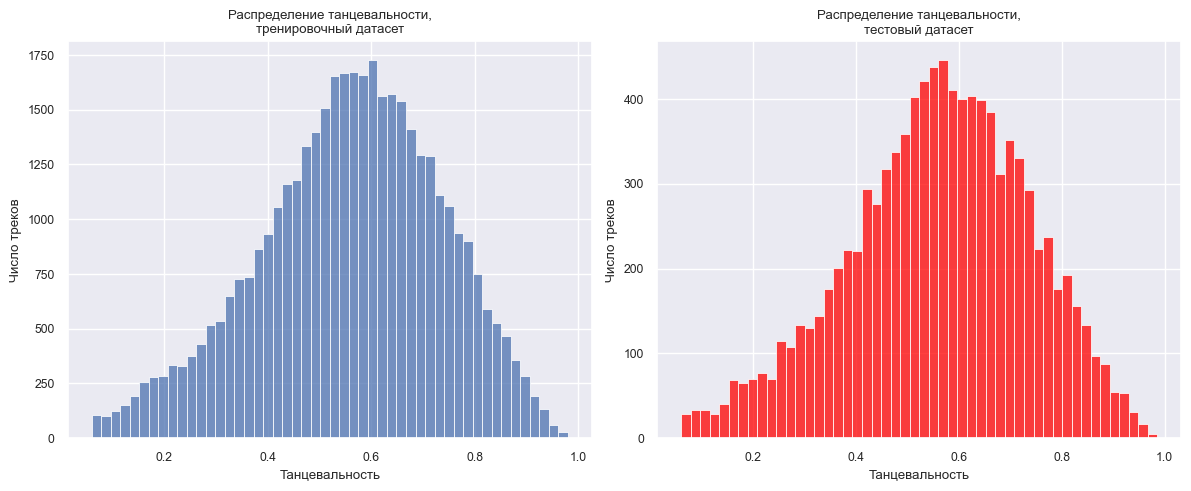

In [126]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
sb.histplot(data=df_train, x="danceability", bins=50, ax=axs[0]).set(
    xlabel='Танцевальность', ylabel='Число треков', title='Распределение танцевальности,\nтренировочный датасет')
sb.histplot(data=df_test, x="danceability", bins=50, ax=axs[1], color='red',).set(
    xlabel='Танцевальность', ylabel='Число треков', title='Распределение танцевальности,\nтестовый датасет')
plt.tight_layout() 
plt.show()

### Столбец `tempo`

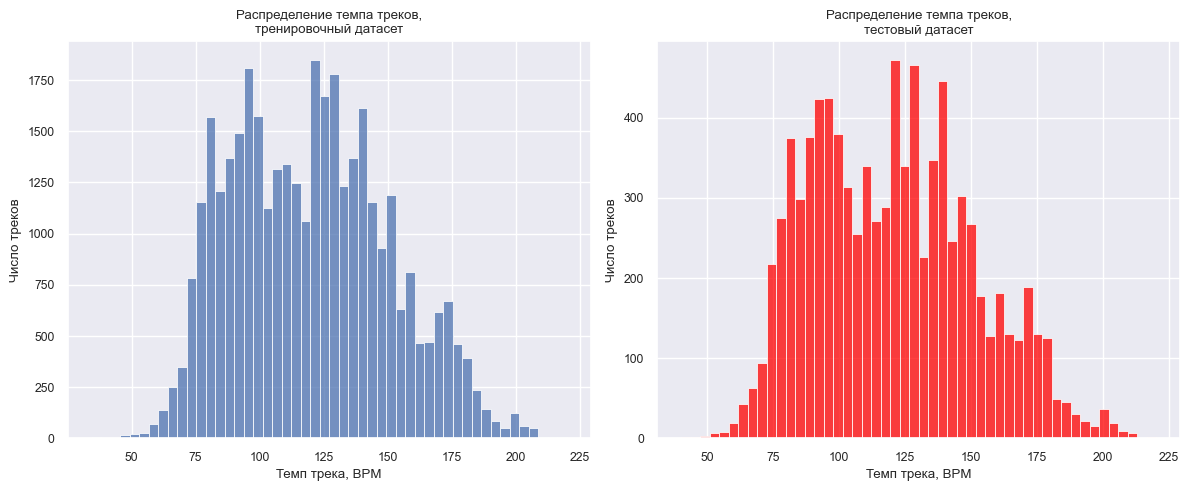

In [127]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
sb.histplot(data=df_train, x="tempo", bins=50, ax=axs[0]).set(
    xlabel='Темп трека, BPM', ylabel='Число треков', title='Распределение темпа треков,\nтренировочный датасет')
sb.histplot(data=df_test, x="tempo", bins=50, ax=axs[1], color='red',).set(
    xlabel='Темп трека, BPM', ylabel='Число треков', title='Распределение темпа треков,\nтестовый датасет')
plt.tight_layout() 
plt.show()

In [128]:
print(f'Число пропусков в столбце tempo в датасете train: '
      f'{df_train["tempo"].isna().sum()}, {df_train["tempo"].isna().sum()/len(df_train)*100:.1f}%')
print(f'Число пропусков в столбце tempo в датасете test: '
      f'{df_test["tempo"].isna().sum()}, {df_test["tempo"].isna().sum()/len(df_test)*100:.1f}%')

Число пропусков в столбце tempo в датасете train: 3979, 9.9%
Число пропусков в столбце tempo в датасете test: 1001, 10.0%


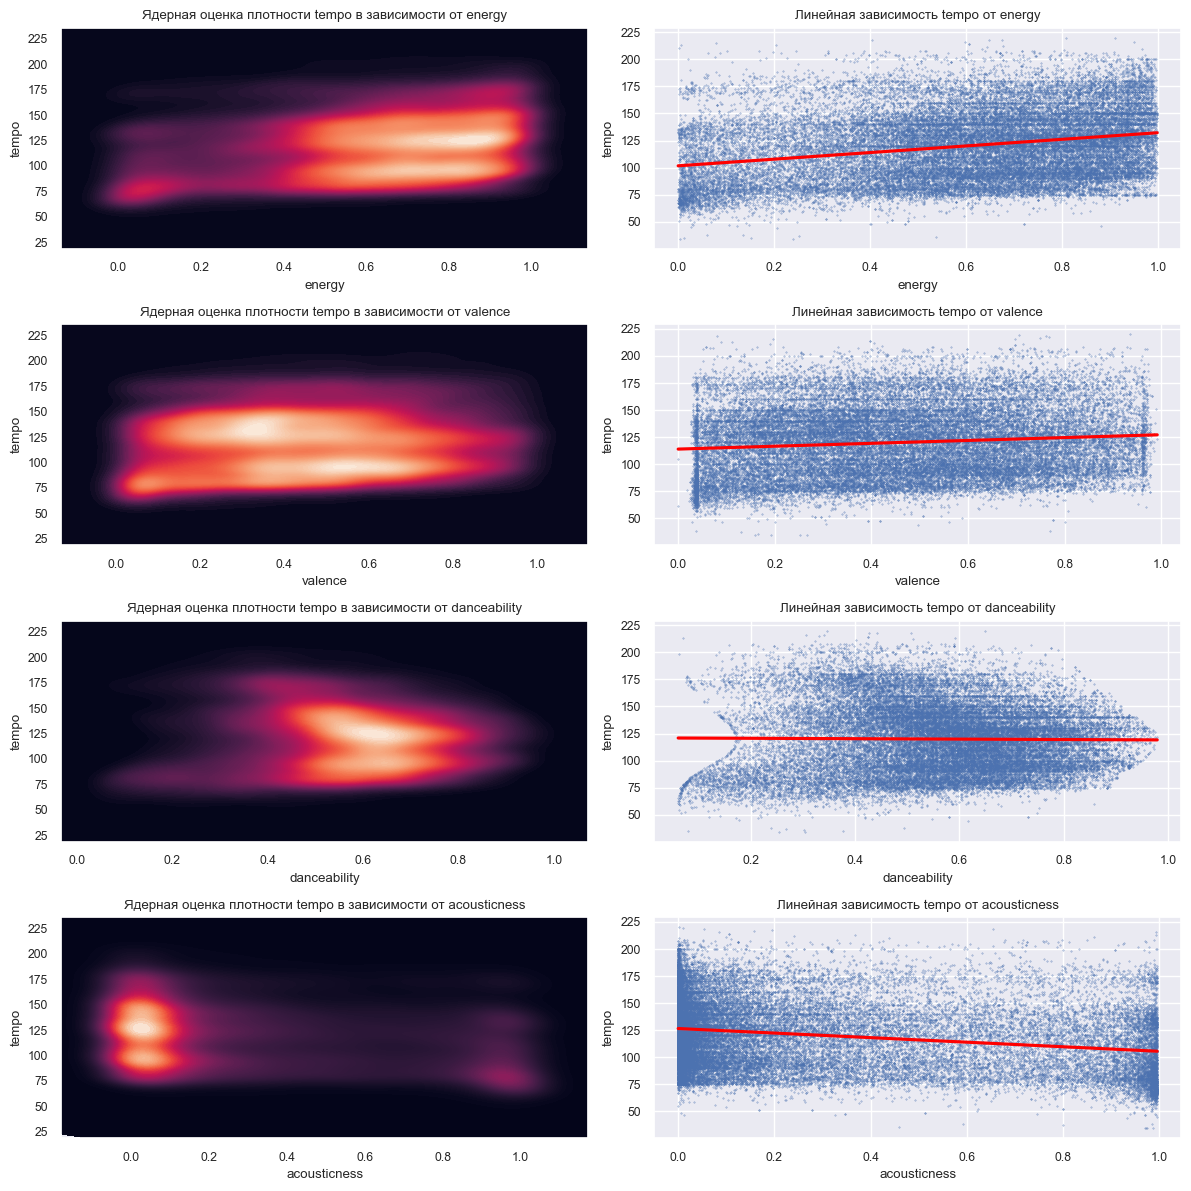

In [129]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
axs = axs.flatten()
columns = ['energy','valence','danceability','acousticness']
for idx, column in enumerate(columns):
    sb.kdeplot(data=df_train, x=column, y="tempo", fill=True, thresh=0, levels=100, cmap="rocket", ax=axs[idx*2]).set(
        title=f'Ядерная оценка плотности tempo в зависимости от {column}', xlabel=column, ylabel='tempo')
    sb.regplot(data=df_train, x=column, y="tempo", scatter_kws={'s':0.1}, line_kws={"color": "red"}, ax=axs[idx*2+1]).set(
        title=f'Линейная зависимость tempo от {column}', xlabel=column, ylabel='tempo')
plt.tight_layout() 
plt.show()

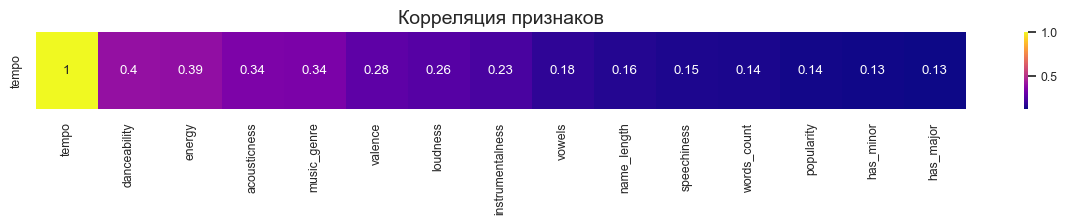

In [130]:
plt.figure(figsize=(15, 1))
sb.heatmap(corr_matrix[['tempo']].sort_values(
    by='tempo',ascending=False).head(15).T, annot=True, cmap='plasma')
plt.title('Корреляция признаков', fontsize=14)
plt.show()

Восстановим пропущенные значения `tempo`:

In [131]:
regressor_features_columns  = ['energy','valence','danceability','acousticness','loudness','vowels','name_length','instrumentalness','speechiness','popularity']
regressor_target_columns    = ['tempo']

df_for_tempo_regressor = df_train.dropna(subset=['tempo','popularity'])
X = df_for_tempo_regressor[regressor_features_columns]
Y = df_for_tempo_regressor[regressor_target_columns].values.ravel()

print(cross_val_score(DummyRegressor(strategy='median'), X, Y, cv=5).mean())
print(cross_val_score(LinearRegression(), X, Y, cv=5).mean())
print(cross_val_score(HistGradientBoostingRegressor(random_state=42), X, Y, cv=5).mean())

-2.0711231003112118e-05
0.08661992128494603
0.15413701826752496


In [132]:
tempo_regressor = HistGradientBoostingRegressor(random_state=42)
_ = tempo_regressor.fit(X, Y)

def get_tempo(row):
    if pd.isna(row[regressor_target_columns][0]):
        return tempo_regressor.predict(row[regressor_features_columns].to_frame(0).T)[0]
    else:
        return row[regressor_target_columns][0]

df_train['tempo'] = df_train.apply(lambda row: get_tempo(row), axis=1)
df_test['tempo']  = df_test.apply(lambda row: get_tempo(row), axis=1)

Распределение данных в столбце после заполнения пропусков:

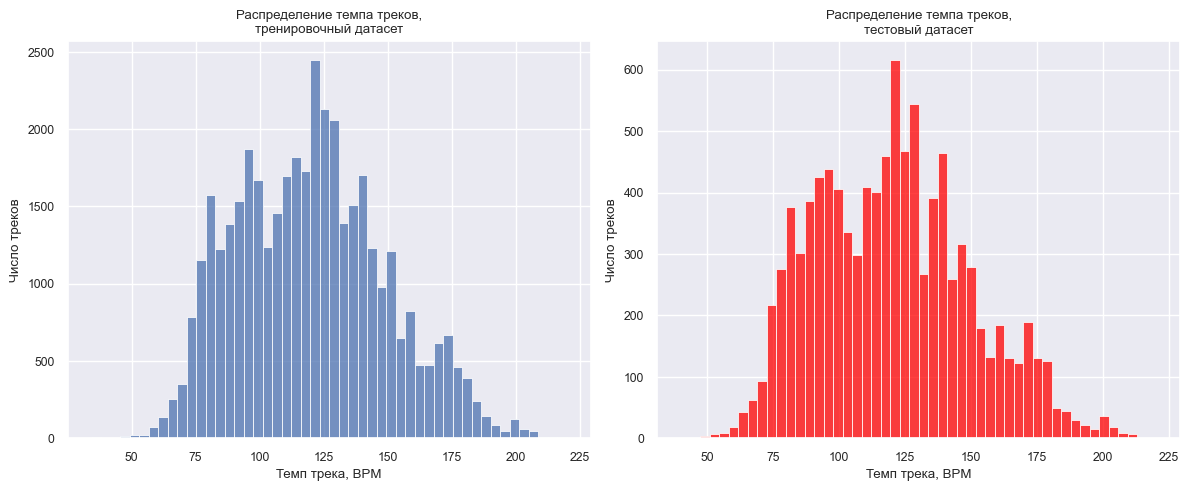

In [133]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
sb.histplot(data=df_train, x="tempo", bins=50, ax=axs[0]).set(
    xlabel='Темп трека, BPM', ylabel='Число треков', title='Распределение темпа треков,\nтренировочный датасет')
sb.histplot(data=df_test, x="tempo", bins=50, ax=axs[1], color='red',).set(
    xlabel='Темп трека, BPM', ylabel='Число треков', title='Распределение темпа треков,\nтестовый датасет')
plt.tight_layout() 
plt.show()

### Столбец `acousticness`

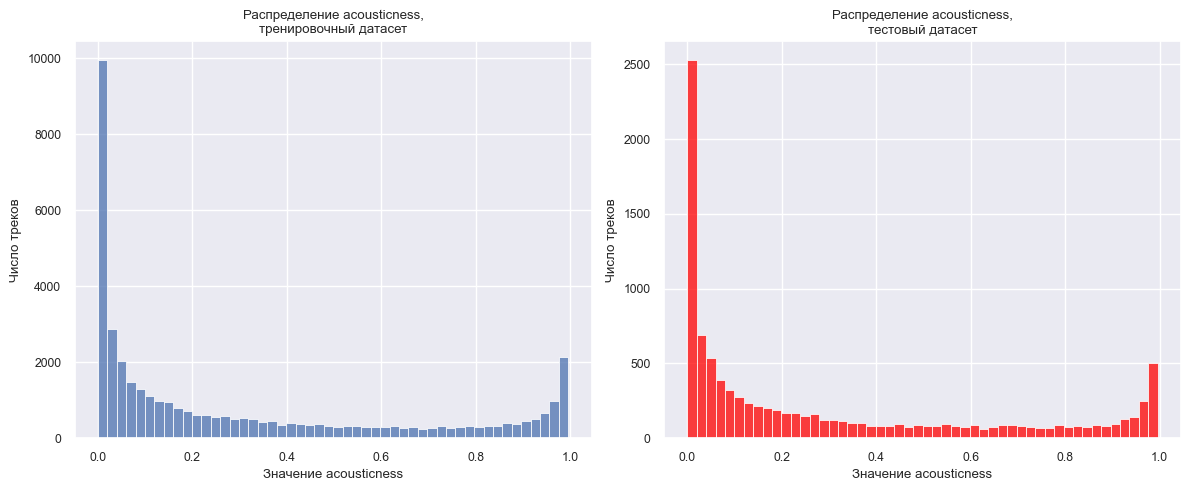

In [134]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
sb.histplot(data=df_train, x="acousticness", bins=50, ax=axs[0]).set(
    xlabel='Значение acousticness', ylabel='Число треков', title='Распределение acousticness,\nтренировочный датасет')
sb.histplot(data=df_test, x="acousticness", bins=50, ax=axs[1], color='red',).set(
    xlabel='Значение acousticness', ylabel='Число треков', title='Распределение acousticness,\nтестовый датасет')
plt.tight_layout() 
plt.show()

### Столбец `energy`

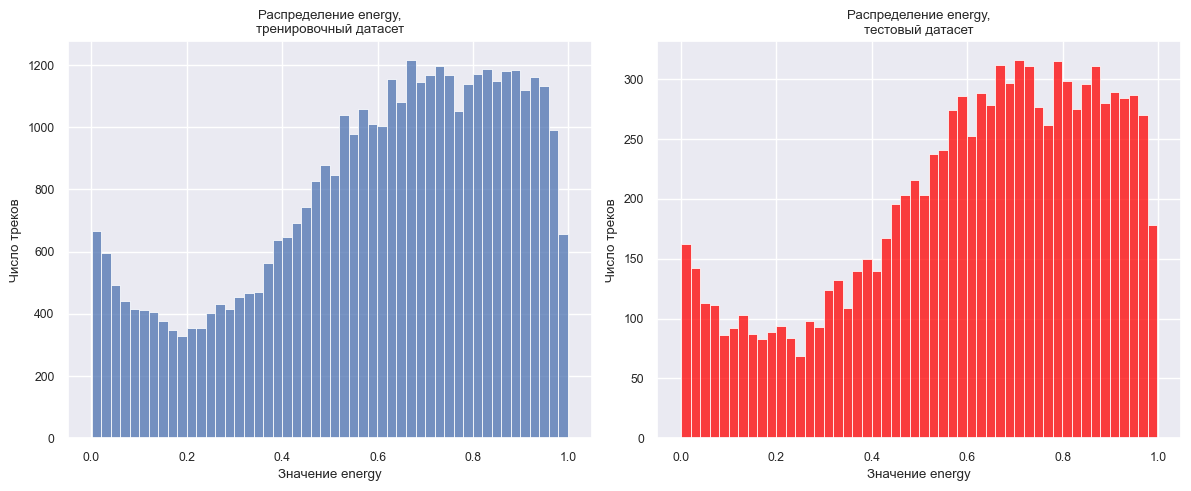

In [135]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
sb.histplot(data=df_train, x="energy", bins=50, ax=axs[0]).set(
    xlabel='Значение energy', ylabel='Число треков', title='Распределение energy,\nтренировочный датасет')
sb.histplot(data=df_test, x="energy", bins=50, ax=axs[1], color='red',).set(
    xlabel='Значение energy', ylabel='Число треков', title='Распределение energy,\nтестовый датасет')
plt.tight_layout() 
plt.show()

### Столбец `instrumentalness`

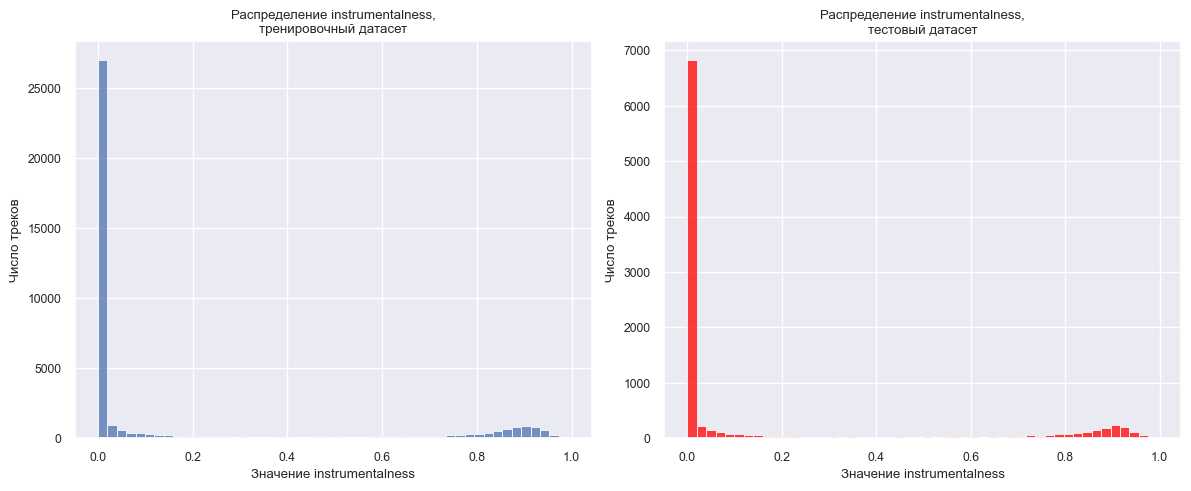

In [136]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
sb.histplot(data=df_train, x="instrumentalness", bins=50, ax=axs[0]).set(
    xlabel='Значение instrumentalness', ylabel='Число треков', title='Распределение instrumentalness,\nтренировочный датасет')
sb.histplot(data=df_test, x="instrumentalness", bins=50, ax=axs[1], color='red',).set(
    xlabel='Значение instrumentalness', ylabel='Число треков', title='Распределение instrumentalness,\nтестовый датасет')
plt.tight_layout() 
plt.show()

### Столбец `liveness`

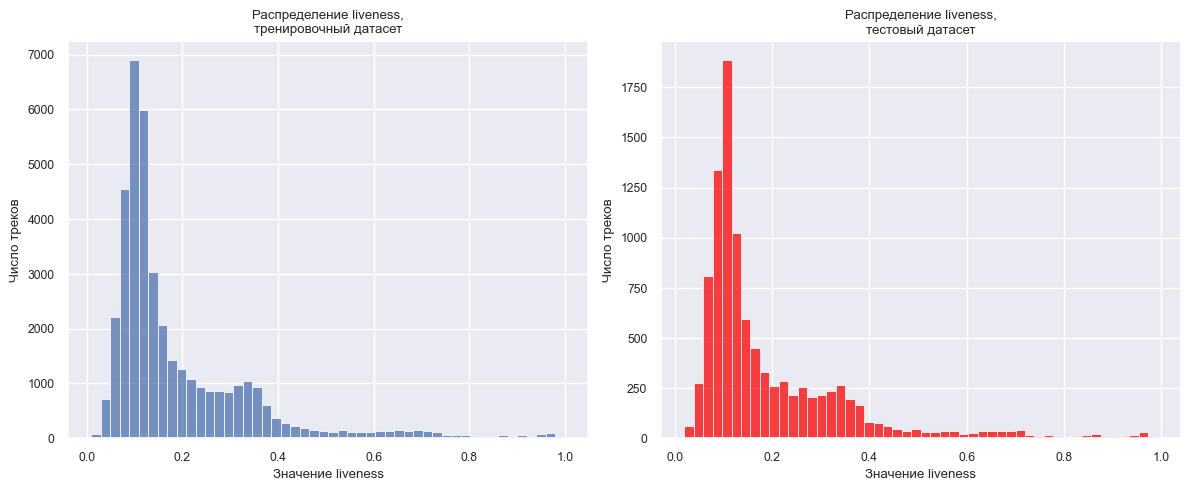

In [137]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
sb.histplot(data=df_train, x="liveness", bins=50, ax=axs[0]).set(
    xlabel='Значение liveness', ylabel='Число треков', title='Распределение liveness,\nтренировочный датасет')
sb.histplot(data=df_test, x="liveness", bins=50, ax=axs[1], color='red',).set(
    xlabel='Значение liveness', ylabel='Число треков', title='Распределение liveness,\nтестовый датасет')
plt.tight_layout() 
plt.show()

### Столбец `loudness`

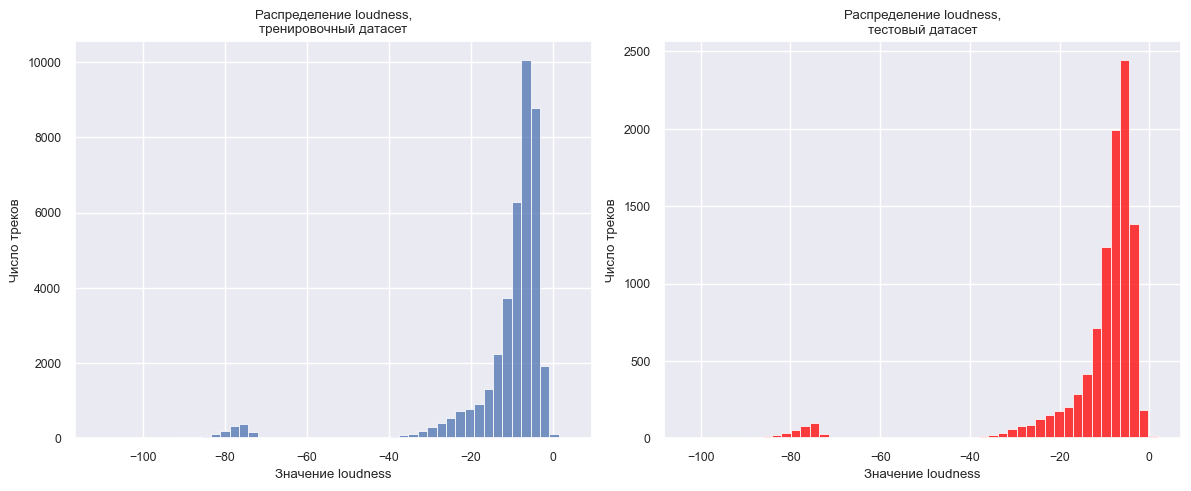

In [138]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
sb.histplot(data=df_train, x="loudness", bins=50, ax=axs[0]).set(
    xlabel='Значение loudness', ylabel='Число треков', title='Распределение loudness,\nтренировочный датасет')
sb.histplot(data=df_test, x="loudness", bins=50, ax=axs[1], color='red',).set(
    xlabel='Значение loudness', ylabel='Число треков', title='Распределение loudness,\nтестовый датасет')
plt.tight_layout() 
plt.show()

Звук с громкостью ниже -50 дБ уже почти не слышен для человека. Наличие небольшого пика в области -80 дБ вызывает вопросы.

### Столбец `duration_ms`

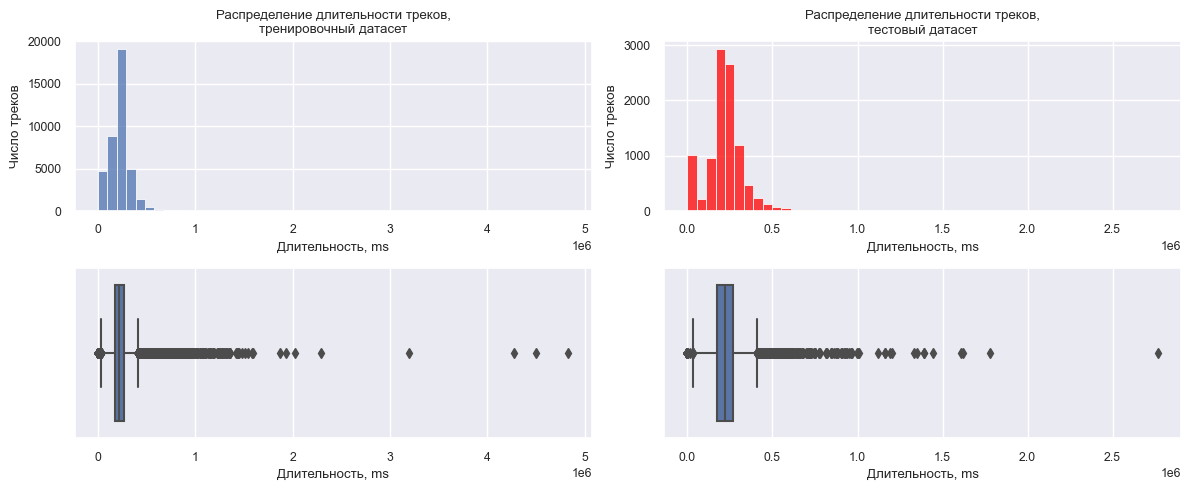

In [139]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
axs = axs.flatten()
sb.histplot(data=df_train, x="duration_ms", bins=50, ax=axs[0]).set(
    xlabel='Длительность, ms', ylabel='Число треков', title='Распределение длительности треков,\nтренировочный датасет')
sb.histplot(data=df_test, x="duration_ms", bins=50, ax=axs[1], color='red',).set(
    xlabel='Длительность, ms', ylabel='Число треков', title='Распределение длительности треков,\nтестовый датасет')
sb.boxplot(x="duration_ms", data=df_train, ax=axs[2]).set(xlabel='Длительность, ms')
sb.boxplot(x="duration_ms", data=df_test, ax=axs[3]).set(xlabel='Длительность, ms')
plt.tight_layout() 
plt.show()

В столбце присутствуют пропуски заполненные значением `-1`. Заменим пропуски на медианное значение длительности:

In [140]:
duration_median = df_train.query('duration_ms >= 0')['duration_ms'].median()
df_train.loc[df_train['duration_ms']==-1,'duration_ms'] = duration_median
df_test.loc[df_test['duration_ms']==-1,'duration_ms'] = duration_median

In [141]:
df_train['duration_sec'] = round(df_train['duration_ms'] / 1000).astype(int)
df_test['duration_sec'] = round(df_test['duration_ms'] / 1000).astype(int)

### Столбец `speechiness`

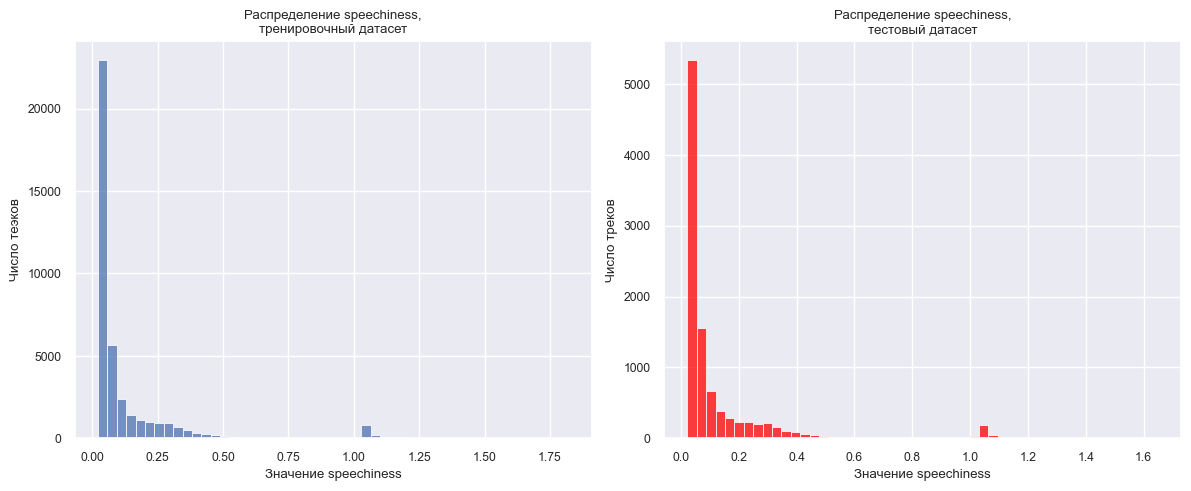

In [142]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
sb.histplot(data=df_train, x="speechiness", bins=50, ax=axs[0]).set(
    xlabel='Значение speechiness', ylabel='Число теэков', title='Распределение speechiness,\nтренировочный датасет')
sb.histplot(data=df_test, x="speechiness", bins=50, ax=axs[1], color='red',).set(
    xlabel='Значение speechiness', ylabel='Число треков', title='Распределение speechiness,\nтестовый датасет')
plt.tight_layout() 
plt.show()

В описании датасета явно не указан диапазон значений столбца. Однако, значения больше `1` вызывают вопросы.

### Столбец `valence`

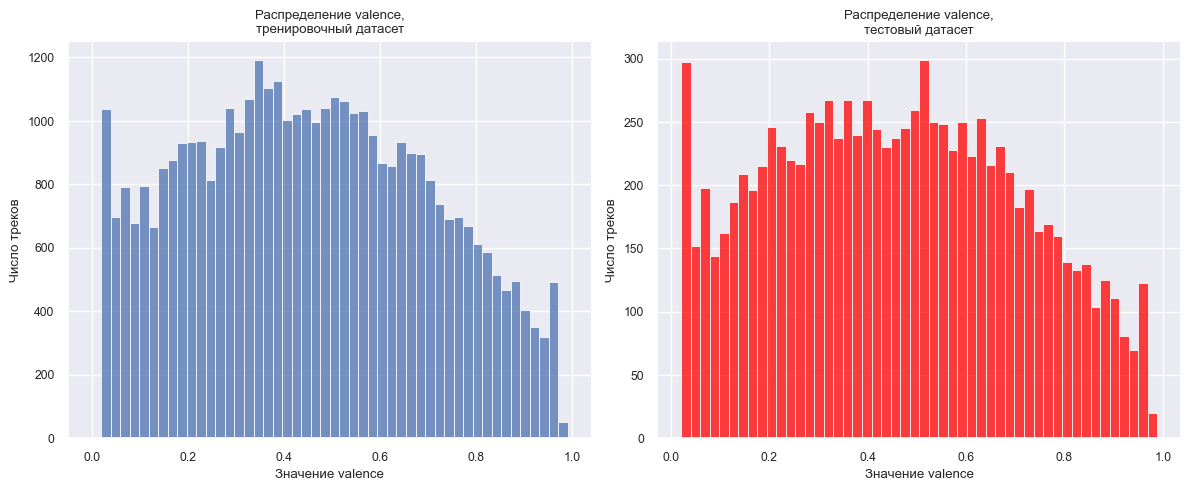

In [143]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
sb.histplot(data=df_train, x="valence", bins=50, ax=axs[0]).set(
    xlabel='Значение valence', ylabel='Число треков', title='Распределение valence,\nтренировочный датасет')
sb.histplot(data=df_test, x="valence", bins=50, ax=axs[1], color='red').set(
    xlabel='Значение valence', ylabel='Число треков', title='Распределение valence,\nтестовый датасет')
plt.tight_layout() 
plt.show()

### Столбец `key`

In [144]:
print(f'Число пропусков в столбце key в датасете train: '
      f'{df_train["key"].isna().sum()}, {df_train["key"].isna().sum()/len(df_train)*100:.1f}%')
print(f'Число пропусков в столбце key в датасете test: '
      f'{df_test["key"].isna().sum()}, {df_test["key"].isna().sum()/len(df_test)*100:.1f}%')

Число пропусков в столбце key в датасете train: 1423, 3.6%
Число пропусков в столбце key в датасете test: 327, 3.3%


In [145]:
df_train["key"] = df_train["key"].fillna('Undefined')
df_test["key"] = df_test["key"].fillna('Undefined')

In [146]:
df_pivot_train = df_train.pivot_table(values='instance_id',index='key', aggfunc=['count']).reset_index()
df_pivot_test = df_test.pivot_table(values='instance_id',index='key', aggfunc=['count']).reset_index()
df_pivot_train.columns = ['key','count']
df_pivot_test.columns  = ['key','count']

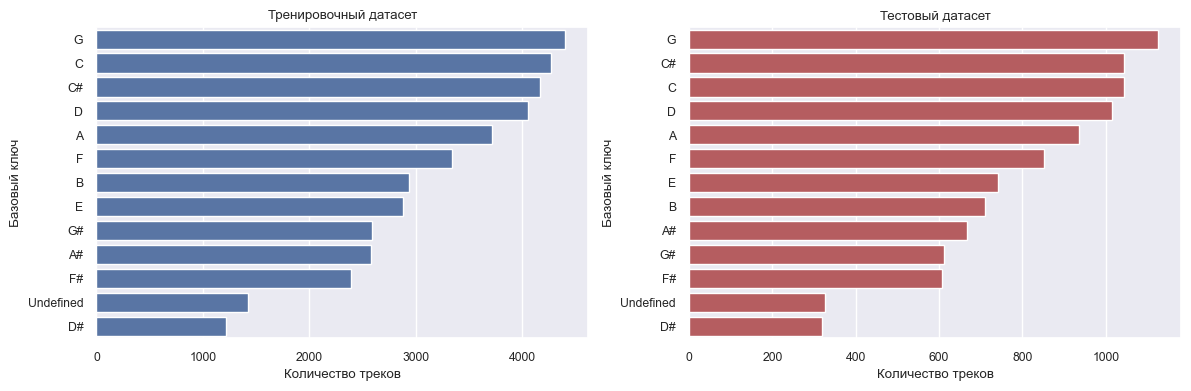

In [147]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs = axs.flatten()
sb.barplot(y='key', x='count', data=df_pivot_train.sort_values(by='count', ascending=False), color="b", orient='h', ax=axs[0]).set(
    title='Тренировочный датасет',xlabel='Количество треков',ylabel='Базовый ключ')
sb.barplot(y='key', x='count', data=df_pivot_test.sort_values(by='count', ascending=False), color="r", orient='h', ax=axs[1]).set(
    title='Тестовый датасет',xlabel='Количество треков',ylabel='Базовый ключ')
plt.tight_layout()
plt.show()

### Столбец `key_hz`

In [46]:
def get_hz(key):
    if key == 'C':
        return 261.63
    if key == 'C#':
        return 277.18
    if key == 'D':
        return 293.66
    if key == 'D#':
        return 311.13
    if key =='E':
        return 311.13
    if key == 'F':
        return 349.23
    if key == 'F#':
        return 369.99
    if key == 'G':
        return 392.00
    if key == 'G#':
        return 415.30
    if key == 'A':
        return 440.00
    if key == 'A#':
        return 466.16
    if key == 'B':
        return 493.88
    return 0

In [47]:
df_train["key_hz"] = df_train.apply(lambda row: get_hz(row['key']), axis = 1)
df_test["key_hz"] = df_test.apply(lambda row: get_hz(row['key']), axis = 1)

In [48]:
key_hz_median = df_train.query('key_hz > 0')['key_hz'].median()
print ('key_hz_median =',key_hz_median)
df_train.loc[df_train["key_hz"] == 0, 'key_hz'] = key_hz_median
df_test.loc[df_test["key_hz"] == 0, 'key_hz']  = key_hz_median

key_hz_median = 349.23


### Столбец `mode`

In [49]:
print(f'Число пропусков в столбце mode в датасете train: '
      f'{df_train["mode"].isna().sum()}, {df_train["mode"].isna().sum()/len(df_train)*100:.1f}%')
print(f'Число пропусков в столбце mode в датасете test: '
      f'{df_test["mode"].isna().sum()}, {df_test["mode"].isna().sum()/len(df_test)*100:.1f}%')

Число пропусков в столбце mode в датасете train: 1853, 4.6%
Число пропусков в столбце mode в датасете test: 482, 4.8%


In [50]:
df_train["mode"] = df_train["mode"].fillna('Undefined')
df_test["mode"] = df_test["mode"].fillna('Undefined')

In [51]:
df_pivot_train = df_train.pivot_table(values='instance_id',index='mode', aggfunc=['count']).reset_index()
df_pivot_test = df_test.pivot_table(values='instance_id',index='mode', aggfunc=['count']).reset_index()
df_pivot_train.columns = ['mode','count']
df_pivot_test.columns  = ['mode','count']

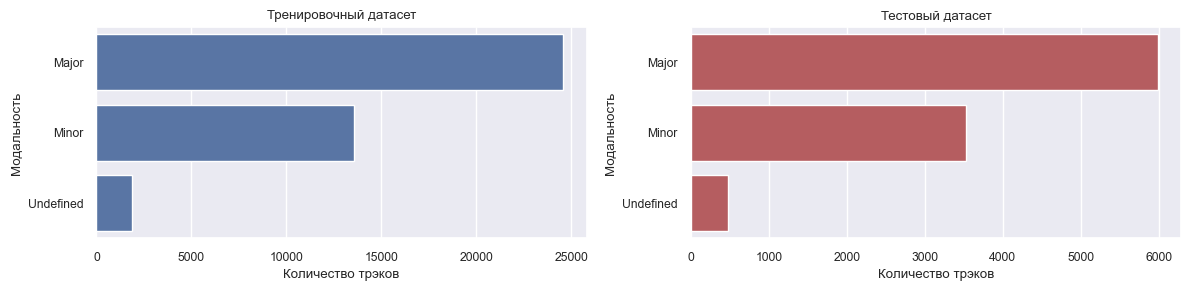

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
axs = axs.flatten()
sb.barplot(y='mode', x='count', data=df_pivot_train, color="b", orient='h', ax=axs[0]).set(
    title='Тренировочный датасет',xlabel='Количество треков',ylabel='Модальность')
sb.barplot(y='mode', x='count', data=df_pivot_test, color="r", orient='h', ax=axs[1]).set(
    title='Тестовый датасет',xlabel='Количество треков',ylabel='Модальность')
plt.tight_layout()
plt.show()

### Столбец `popularity`

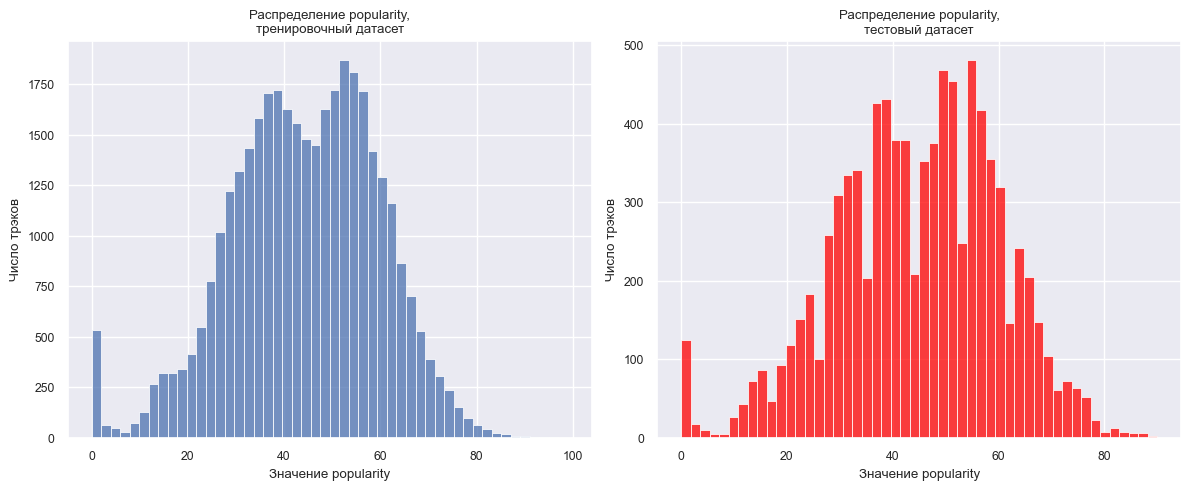

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
sb.histplot(data=df_train, x="popularity", bins=50, ax=axs[0]).set(
    xlabel='Значение popularity', ylabel='Число треков', title='Распределение popularity,\nтренировочный датасет')
sb.histplot(data=df_test, x="popularity", bins=50, ax=axs[1], color='red').set(
    xlabel='Значение popularity', ylabel='Число треков', title='Распределение popularity,\nтестовый датасет')
plt.tight_layout() 
plt.show()

In [54]:
print(f'Число пропусков в столбце popularity в датасете train: '
      f'{df_train["popularity"].isna().sum()}, {df_train["popularity"].isna().sum()/len(df_train)*100:.1f}%')
print(f'Число пропусков в столбце popularity в датасете test: '
      f'{df_test["popularity"].isna().sum()}, {df_test["popularity"].isna().sum()/len(df_test)*100:.1f}%')

Число пропусков в столбце popularity в датасете train: 3922, 9.8%
Число пропусков в столбце popularity в датасете test: 1013, 10.1%


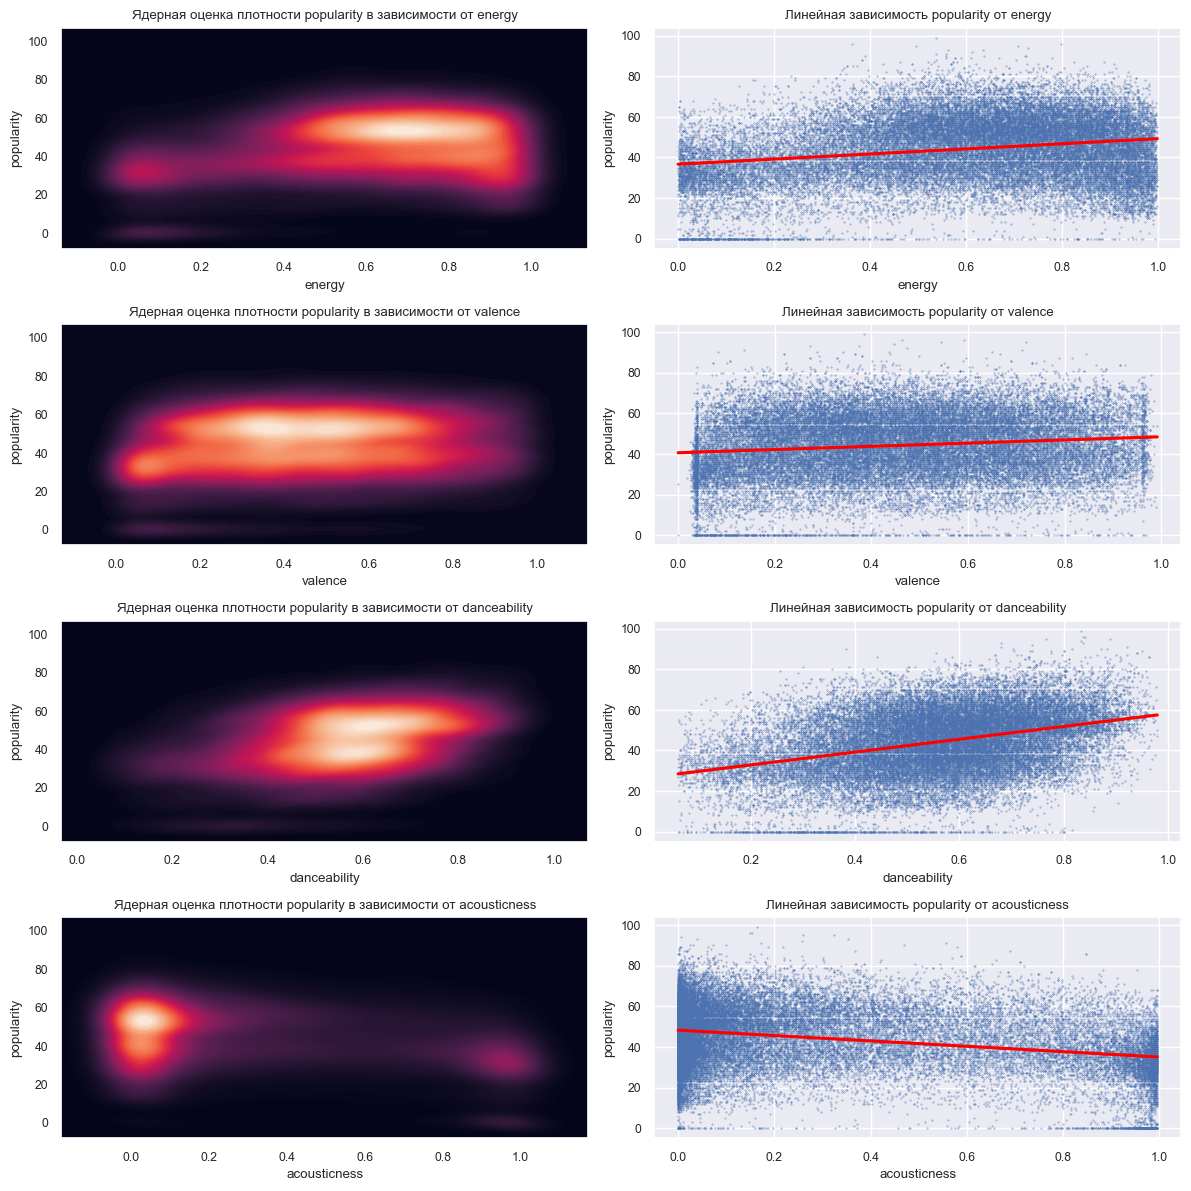

In [55]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
axs = axs.flatten()
columns = ['energy','valence','danceability','acousticness']
for idx, column in enumerate(columns):
    sb.kdeplot(data=df_train, x=column, y="popularity", fill=True, thresh=0, levels=100, cmap="rocket", ax=axs[idx*2]).set(
        title=f'Ядерная оценка плотности popularity в зависимости от {column}', xlabel=column, ylabel='popularity')
    sb.regplot(data=df_train, x=column, y="popularity", scatter_kws={'s':0.1}, line_kws={"color": "red"}, ax=axs[idx*2+1]).set(
        title=f'Линейная зависимость popularity от {column}', xlabel=column, ylabel='popularity')
plt.tight_layout() 
plt.show()

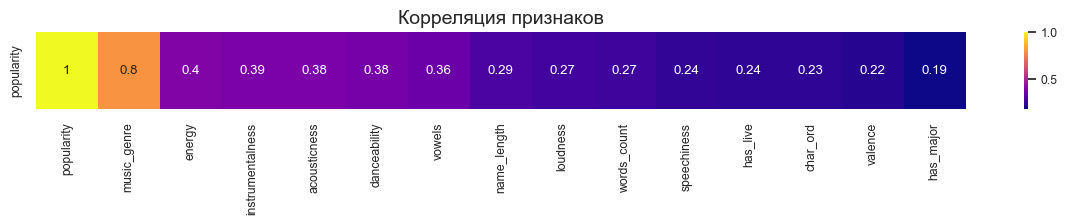

In [56]:
plt.figure(figsize=(15, 1))
sb.heatmap(corr_matrix[['popularity']].sort_values(
    by='popularity',ascending=False).head(15).T, annot=True, cmap='plasma')
plt.title('Корреляция признаков', fontsize=14)
plt.show()

Восстановим пропущенные значения `popularity`:

In [57]:
regressor_features_columns  = ['energy','valence','danceability','acousticness','loudness','tempo','vowels','name_length','has_live']
regressor_target_columns    = ['popularity']
df_for_popularity_regressor = df_train.dropna(subset=['popularity'])
X = df_for_popularity_regressor[regressor_features_columns]
Y = df_for_popularity_regressor[regressor_target_columns].values.ravel()

print(cross_val_score(DummyRegressor(strategy='median'), X, Y, cv=5).mean())
print(cross_val_score(LinearRegression(), X, Y, cv=5).mean())
print(cross_val_score(HistGradientBoostingRegressor(random_state=42), X, Y, cv=5).mean())

-0.0028414310189222467
0.17239845718582286
0.260048811802094


In [58]:
popularity_regressor = HistGradientBoostingRegressor(random_state=42)
_ = popularity_regressor.fit(X, Y)

def get_popularity(row):
    if pd.isna(row[regressor_target_columns][0]):
        return popularity_regressor.predict(row[regressor_features_columns].to_frame(0).T)[0]
    else:
        return row[regressor_target_columns][0]

df_train['popularity'] = df_train.apply(lambda row: get_popularity(row), axis=1)
df_test['popularity'] = df_test.apply(lambda row: get_popularity(row), axis=1)

Распределение данных в столбце после заполнения пропусков:

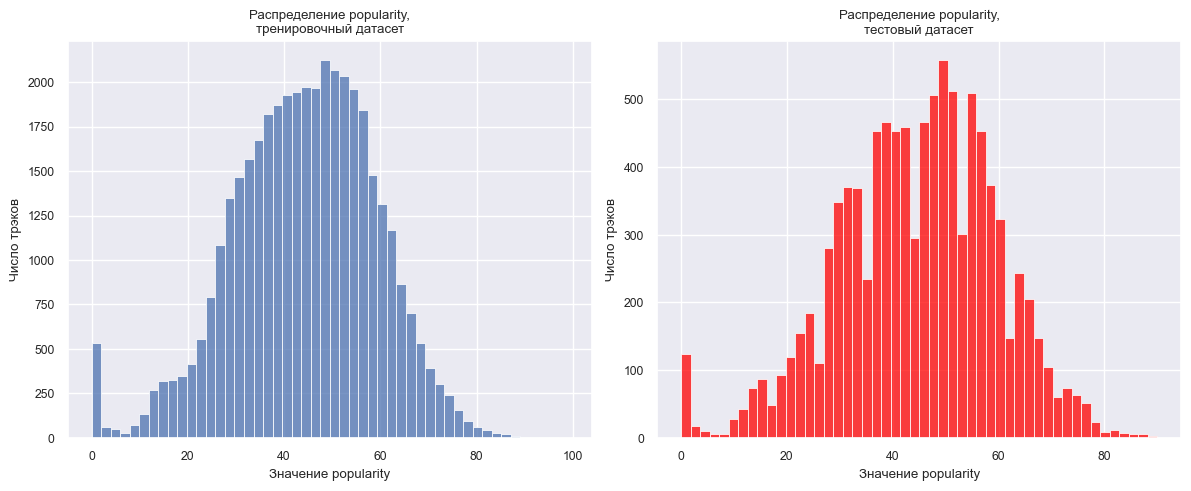

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
sb.histplot(data=df_train, x="popularity", bins=50, ax=axs[0]).set(
    xlabel='Значение popularity', ylabel='Число треков', title='Распределение popularity,\nтренировочный датасет')
sb.histplot(data=df_test, x="popularity", bins=50, ax=axs[1], color='red').set(
    xlabel='Значение popularity', ylabel='Число треков', title='Распределение popularity,\nтестовый датасет')
plt.tight_layout() 
plt.show()

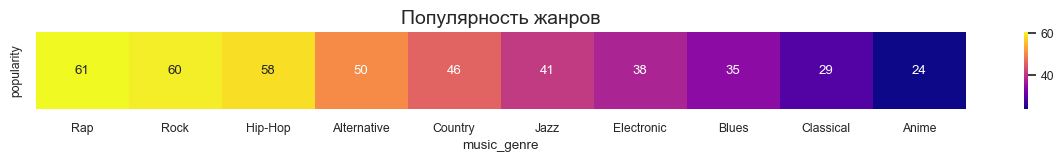

In [165]:
df_popolarity_pivot = df_train.pivot_table(
    index=['music_genre'], 
    values=['popularity'], 
    aggfunc='mean').sort_values(by='popularity', ascending=False)

plt.figure(figsize=(15, 1))
sb.heatmap(df_popolarity_pivot.T, annot=True, cmap='plasma')
plt.title('Популярность жанров', fontsize=14)
plt.show()

### Целевой признак `music_genre`

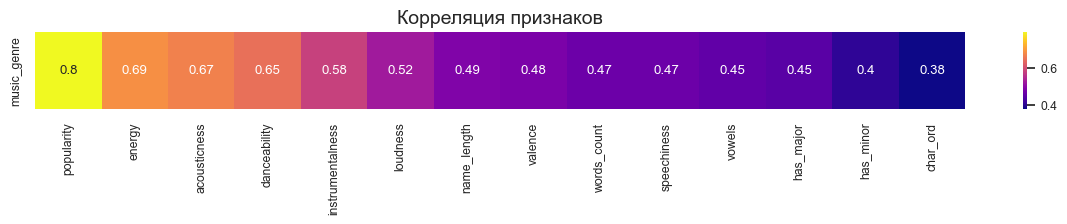

In [174]:
plt.figure(figsize=(15, 1))
sb.heatmap(corr_matrix[['music_genre']].sort_values(
    by='music_genre',ascending=False).head(15).T.drop('music_genre', axis=1), annot=True, cmap='plasma')
plt.title('Корреляция признаков', fontsize=14)
plt.show()

In [60]:
df_pivot_train = df_train.pivot_table(values='instance_id',index='music_genre', aggfunc=['count']).reset_index()
df_pivot_train.columns = ['music_genre','count']

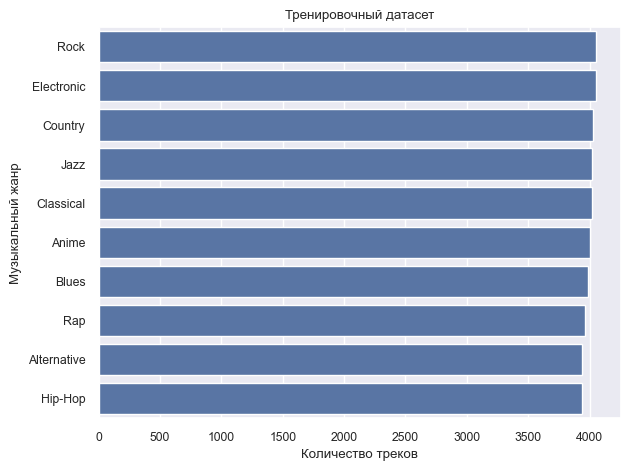

In [102]:
sb.barplot(y='music_genre', x='count', data=df_pivot_train.sort_values(
    by='count', ascending=False), color="b", orient='h').set(
    title='Тренировочный датасет',xlabel='Количество треков',ylabel='Музыкальный жанр')
plt.tight_layout()
plt.show()

### Выводы по разделу

* На основе названия трека `track_name` сформировано несколько новых признаков: длина имени, число слов, доля гласных, средний код символа, содержание специальных слов, содержание знака вопроса и знака восклицания;

* Таблица корреляции признаков показывает, что жанр произведения имеет довольно сильную взаимосвязь с `popularity`, `danceability`, `energy`, `instrumentalness`, `loudness`; <br><br> 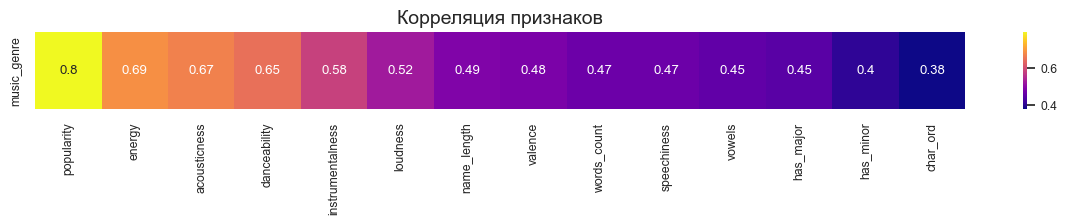

* Пропуски в столбцах `tempo`, `danceability` и `popularity` заполнены с помощью математической модели, которая предсказывает эти признаки на основе других признаков трека. Для регрессии использовался `HistGradientBoostingRegressor`;

* Обнаружены неявные пропуски (значение `-1`) в столбце `duration_ms`. Пропуски заполнены медианным значением столбца. Поскольку точность до миллисекунд скорее всего избыточна, сформирован столбец `duration_sec` с продолжительностью трека в секундах;

* Пропуски в столбцах `mode` и `key` заполнены значением `Undefined`;

* На основе столбца `key` сформирован новый столбец `key_hz`, который содержит частоту соответствующей ноты. Пропущенные ноты из столбца `key` заполнены медианным значением `key_hz`;

* Столбцы `obtained_date` и `instance_id` не несут полезной информации для обучения модели;

* Столбец `popularity` возможно содержит в себе утечку целевого признака. Например, треки в жанре поп-музыки будут заведомо иметь большую популярность чем классическая музыка. Кроме того, в момент загрузки нового произведения его популярность еще не известна;

* Наибольшей популярностью в датасете пользуются жанры `Rap` и `Rock`, а наименьшей `Anime` и `Classical`;

* Дисбаланс классов целевого признака отсутствует.

## Подготовка признаков для обучения моделей

### Очистка неинформативных столбцов 

In [62]:
columns_to_drop = ['instance_id','track_name','obtained_date','words_count','duration_ms','key']

df_train_clear = df_train.drop(columns_to_drop,axis=1)
df_test_clear  = df_test.drop(columns_to_drop,axis=1)
df_train_clear.head()

,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,music_genre,name_length,has_exclamation,has_question,has_blues,has_feat,has_symphony,has_sonata,has_piano,has_live,has_mix,has_remastered,has_remix,has_major,has_minor,vowels,char_ord,duration_sec,key_hz
0,33.00,0.00,0.50,0.94,0.02,0.08,-5.57,Minor,0.16,144.92,0.19,Electronic,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33,89.25,227,415.30
1,55.00,0.06,0.28,0.74,0.01,0.29,-5.57,Major,0.03,126.91,0.21,Alternative,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.32,90.56,288,261.63
2,39.00,0.93,0.36,0.35,0.94,0.11,-13.28,Undefined,0.03,65.43,0.09,Classical,27,0,0,0,0,1,0,0,0,0,0,0,0,0,0.22,83.74,115,349.23
3,56.00,0.01,0.33,0.85,0.00,0.30,-4.51,Minor,0.09,67.23,0.39,Electronic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.32,90.56,235,493.88
4,52.00,0.58,0.72,0.61,0.00,0.16,-7.10,Major,0.04,88.01,0.68,Country,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0.31,97.77,222,392.00


In [63]:
df_train_clear.shape, df_test_clear.shape

((40000, 30), (10000, 29))

### Кодирование категориальных признаков

In [64]:
OHE_columns = ["mode"]

In [65]:
OHE_encoder = OneHotEncoder(handle_unknown='error', drop=['Undefined'], sparse=False)
OHE_encoder.fit(df_train_clear[OHE_columns])
OHE_encoder.categories_

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[array(['Major', 'Minor', 'Undefined'], dtype=object)]

In [66]:
df_train_ohe = pd.DataFrame(OHE_encoder.transform(df_train_clear[OHE_columns]), columns=OHE_encoder.get_feature_names_out(OHE_columns))
df_test_ohe  = pd.DataFrame(OHE_encoder.transform(df_test_clear[OHE_columns]),  columns=OHE_encoder.get_feature_names_out(OHE_columns))

In [67]:
df_train_clear = pd.concat([df_train_clear, df_train_ohe], axis=1).drop(OHE_columns, axis=1)
df_test_clear  = pd.concat([df_test_clear, df_test_ohe], axis=1).drop(OHE_columns, axis=1)

In [68]:
df_train_clear.head()

,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,music_genre,name_length,has_exclamation,has_question,has_blues,has_feat,has_symphony,has_sonata,has_piano,has_live,has_mix,has_remastered,has_remix,has_major,has_minor,vowels,char_ord,duration_sec,key_hz,mode_Major,mode_Minor
0,33.00,0.00,0.50,0.94,0.02,0.08,-5.57,0.16,144.92,0.19,Electronic,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33,89.25,227,415.30,0.00,1.00
1,55.00,0.06,0.28,0.74,0.01,0.29,-5.57,0.03,126.91,0.21,Alternative,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.32,90.56,288,261.63,1.00,0.00
2,39.00,0.93,0.36,0.35,0.94,0.11,-13.28,0.03,65.43,0.09,Classical,27,0,0,0,0,1,0,0,0,0,0,0,0,0,0.22,83.74,115,349.23,0.00,0.00
3,56.00,0.01,0.33,0.85,0.00,0.30,-4.51,0.09,67.23,0.39,Electronic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.32,90.56,235,493.88,0.00,1.00
4,52.00,0.58,0.72,0.61,0.00,0.16,-7.10,0.04,88.01,0.68,Country,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0.31,97.77,222,392.00,1.00,0.00


In [69]:
df_train_clear.shape, df_test_clear.shape

((40000, 31), (10000, 30))

### Масштабирование признаков

In [70]:
numeric_columns = ['popularity','acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','duration_sec','name_length','key_hz']

In [71]:
scaler = StandardScaler()
scaler.fit(df_train_clear[numeric_columns])
df_train_clear[numeric_columns] = scaler.transform(df_train_clear[numeric_columns])
df_test_clear[numeric_columns] = scaler.transform(df_test_clear[numeric_columns])

In [72]:
df_train_clear.head()

,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,music_genre,name_length,has_exclamation,has_question,has_blues,has_feat,has_symphony,has_sonata,has_piano,has_live,has_mix,has_remastered,has_remix,has_major,has_minor,vowels,char_ord,duration_sec,key_hz,mode_Major,mode_Minor
0,-0.75,-0.90,-0.32,1.27,-0.50,-0.68,0.42,0.13,0.85,-1.08,Electronic,-0.17,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33,89.25,-0.16,0.76,0.00,1.00
1,0.72,-0.71,-1.56,0.53,-0.52,0.60,0.42,-0.46,0.24,-0.99,Alternative,-0.86,0,0,0,0,0,0,0,0,0,0,0,0,0,0.32,90.56,0.41,-1.33,1.00,0.00
2,-0.34,1.82,-1.10,-0.94,2.32,-0.52,-0.11,-0.46,-1.86,-1.49,Classical,0.70,0,0,0,0,1,0,0,0,0,0,0,0,0,0.22,83.74,-1.20,-0.14,0.00,0.00
3,0.79,-0.86,-1.28,0.94,-0.56,0.64,0.50,-0.18,-1.80,-0.26,Electronic,-0.86,0,0,0,0,0,0,0,0,0,0,0,0,0,0.32,90.56,-0.08,1.82,0.00,1.00
4,0.52,0.80,0.89,0.06,-0.56,-0.21,0.32,-0.44,-1.09,0.91,Country,-0.11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.31,97.77,-0.20,0.44,1.00,0.00


In [73]:
df_train_clear.shape, df_test_clear.shape

((40000, 31), (10000, 30))

### Подготовка признаков и целевого признака

In [74]:
df_features_train = df_train_clear.drop(['music_genre'], axis=1)
df_target_train   = df_train_clear['music_genre']
df_features_test  = df_test_clear.drop([], axis=1)

In [75]:
df_features_train.shape, df_target_train.shape, df_features_test.shape

((40000, 30), (40000,), (10000, 30))

### Выводы по разделу

* Признаки `instance_id`, и `obtained_date` исключены из обучения модели, т.к. не имеют предсказательной силы;

* Вместо признака `duration_ms` для обучения используется `duration_sec`, а вместо признака `key` его количественный аналог `key_hz`;

* Для признака `mode` применено `OHE` кодирование;

* Масштабирование признаков с помощью `StandartScaler` применено для `popularity`, `acousticness`, `danceability`, `energy`, `instrumentalness`, `liveness`, `loudness`, `speechiness`, `tempo`, `valence`, `duration_sec`, `name_length`, `key_hz`;

* Итоговый датасет для обучения имеет 40.000 наблюдений из 30 признаков и одного целевого признака `music_genre`. Датасет для тестирования имеет 10.000 наблюдений из 30 признаков.

## Выбор модели

In [76]:
rnd_seed = 24092010
print('Random Seed установлен:', rnd_seed)

Random Seed установлен: 24092010


In [77]:
def get_model_score(classifier, parametrs, features_t, target_t, base_metric):
    """ Функция подбирает оптимальные гипер-параметры 
        и вычисляет выбранную целевую метрику с помощью кросс-валидации.

        Параметры
        ----------
        classifier : BaseEstimator
            классификатор
        parameters : dict
            диапазон гипер-параметров для поиска лучшей модели
        features_t : pd.DataFrame
            признаки обучающей выборки
        target_t : pd.DataFrame
            целевой признак обучающий выборкиэ
        base_metric : str
            целевая метрика
    """
    grid = GridSearchCV(classifier, parametrs, n_jobs=-1, verbose=0, scoring=base_metric)
    grid.fit(features_t, target_t)

    best_model  = grid.best_estimator_
    best_params = grid.best_params_
    score_mean  = grid.cv_results_['mean_test_score'][grid.best_index_]
    score_std   = grid.cv_results_['std_test_score'][grid.best_index_]
    
    print(f'Классификатор: {classifier.__class__.__name__}')
    print('Подобранные гиперпараметры:', best_params)
    print(f'Метрика {base_metric}: {score_mean:.4f} ± {score_std:.4f}')
    print ('═' * 91 + '\n')

    return best_model, best_params, score_mean, score_std

In [78]:
def test_models_set(models_to_test):
    """ Функция проводит тестирование набора моделей, 
        с различными обучающими выборками, свойствами и наборами гипер-параметров

        Параметры
        ---------
        models_to_test : dict
            Список моделей, диапазон подбора гипер-параметров, признак и целевой признак для обучения
        
        Возвращает
        ----------
            Параметры модели, которая показала лучшую заданную метрику на кросс-валидации
    """
    set_best_score = -1
    for model in models_to_test:
        (best_model, best_params, score, score_std) = get_model_score(
            classifier  = model['classifier'],
            parametrs   = model['parametrs'],
            features_t  = model['features_t'],
            target_t    = model['target_t'], 
            base_metric = model['base_metric']
        )

        if (score > set_best_score):
            set_best_score              = score
            set_best_score_std          = score_std
            set_best_model              = best_model
            set_best_model_params       = best_params
            set_best_model_base_metric  = model['base_metric']
    
    return set_best_model, set_best_model_params, set_best_score, set_best_score_std, set_best_model_base_metric

In [79]:
models_to_test = [
    {
        'classifier'     : VotingClassifier(estimators=[
                                ('hgbc1', HistGradientBoostingClassifier()),
                                ('hgbc2', HistGradientBoostingClassifier()),
                                ('hgbc3', HistGradientBoostingClassifier())],
                                voting='soft'),
        'parametrs'      : {
                                'hgbc1__random_state'      : [rnd_seed],
                                'hgbc1__l2_regularization' : [0.001, 0.0001],
                                'hgbc1__max_depth'         : range(1,5,1),
                                'hgbc2__random_state'      : [42],
                                'hgbc2__max_depth'         : range(1,5,1),
                                'hgbc3__random_state'      : [rnd_seed*42],
                                'hgbc3__max_depth'         : range(1,5,1)
                            },
        'features_t'      : df_features_train,
        'target_t'        : df_target_train,
        'base_metric'     : 'f1_micro'  
    },
    {
        'classifier'      : DecisionTreeClassifier(),
        'parametrs'       : {'max_depth': range(1,20,1), 'random_state':[rnd_seed]},
        'features_t'      : df_features_train,
        'target_t'        : df_target_train,
        'base_metric'     : 'f1_micro'
    },
    {
        'classifier'      : RandomForestClassifier(),
        'parametrs'       : {'max_depth': range(5,20,5), 'n_estimators': range(25,50,25), 'random_state':[rnd_seed]},
        'features_t'      : df_features_train,
        'target_t'        : df_target_train,
        'base_metric'     : 'f1_micro'
    },
    {
        'classifier'      : GradientBoostingClassifier(),
        'parametrs'       : {'n_estimators': range(5,20,5), 'random_state':[rnd_seed]},
        'features_t'      : df_features_train,
        'target_t'        : df_target_train,
        'base_metric'     : 'f1_micro'
    }
]

In [80]:
(best_model, best_params, best_score, best_score_std, best_model_metric) = test_models_set(models_to_test)

print ('Найденная лучшая модель:')
print (f'Метрика {best_model_metric}: {best_score:.4f} ± {best_score_std:.4f}')
print (f'Классификатор: {best_model.__class__.__name__ }')
print (f'Параметры: {best_params}')

Классификатор: VotingClassifier
Подобранные гиперпараметры: {'hgbc1__l2_regularization': 0.001, 'hgbc1__max_depth': 4, 'hgbc1__random_state': 24092010, 'hgbc2__max_depth': 3, 'hgbc2__random_state': 42, 'hgbc3__max_depth': 4, 'hgbc3__random_state': 1011864420}
Метрика f1_micro: 0.5844 ± 0.0049
═══════════════════════════════════════════════════════════════════════════════════════════

Классификатор: DecisionTreeClassifier
Подобранные гиперпараметры: {'max_depth': 9, 'random_state': 24092010}
Метрика f1_micro: 0.5021 ± 0.0044
═══════════════════════════════════════════════════════════════════════════════════════════

Классификатор: RandomForestClassifier
Подобранные гиперпараметры: {'max_depth': 10, 'n_estimators': 25, 'random_state': 24092010}
Метрика f1_micro: 0.5499 ± 0.0043
═══════════════════════════════════════════════════════════════════════════════════════════

Классификатор: GradientBoostingClassifier
Подобранные гиперпараметры: {'n_estimators': 15, 'random_state': 24092010}
Мет

In [167]:
models_result = [
    {'Классификатор': 'DecisionTreeClassifier', 'F1 Micro': '0.5021', 'Стандартное отклонение': '0.0044'},
    {'Классификатор': 'RandomForestClassifier', 'F1 Micro': '0.5499', 'Стандартное отклонение': '0.0043'},
    {'Классификатор': 'GradientBoostingClassifier', 'F1 Micro': '0.5273', 'Стандартное отклонение': '0.0054'},
    {'Классификатор': 'HistGradientBoostingClassifier (3x Voting)', 'F1 Micro': '0.5844', 'Стандартное отклонение': '0.0049'},
]

pd.DataFrame(models_result).sort_values(by='F1 Micro', ascending=False)

,Классификатор,F1 Micro,Стандартное отклонение
3,HistGradientBoostingClassifier (3x Voting),0.5844,0.0049
1,RandomForestClassifier,0.5499,0.0043
2,GradientBoostingClassifier,0.5273,0.0054
0,DecisionTreeClassifier,0.5021,0.0044


### Выводы по разделу

* Для решения задачи мультиклассификации использовались следующие классификаторы: `DecisionTreeClassifier`, `RandomForestClassifier`, `GradientBoostingClassifier` и `VotingClassifier`, состоящий из ансамбля `трех HistGradientBoostingClassifier`;

* Для обучения и подбора гипер-параметров моделей использовался `GridSearchCV` с разбивкой на 5 кроссвалидационных выборок;

* В качестве целевой метрики для оптимизации использовалась `F1-Micro`;

* Наилучшее значенние целевой метрики достигнуто с помощью ансамбля из трех `HistGradientBoostingClassifier`;

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe" style="margin-left:40px">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Классификатор</th>
      <th>F1 Micro</th>
      <th>Стандартное отклонение</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>3</th>
      <td>HistGradientBoostingClassifier (3x Voting)</td>
      <td>0.5844</td>
      <td>0.0049</td>
    </tr>
    <tr>
      <th>1</th>
      <td>RandomForestClassifier</td>
      <td>0.5499</td>
      <td>0.0043</td>
    </tr>
    <tr>
      <th>2</th>
      <td>GradientBoostingClassifier</td>
      <td>0.5273</td>
      <td>0.0054</td>
    </tr>
    <tr>
      <th>0</th>
      <td>DecisionTreeClassifier</td>
      <td>0.5021</td>
      <td>0.0044</td>
    </tr>
  </tbody>
</table>
</div>

## Обработка тестового датасета

In [81]:
predictions = pd.DataFrame(best_model.predict(df_features_test),columns=['music_genre'])

In [82]:
df_submit = pd.concat([df_test, predictions], axis=1)[['instance_id','music_genre']]
df_submit.head()

,instance_id,music_genre
0,20514,Jazz
1,46957,Hip-Hop
2,5488,Electronic
3,18150,Country
4,20148,Alternative


In [83]:
df_submit.to_csv('predictions/submit_file_v22.csv', index=False)

### Выводы по разделу

На тестовом датасете лучшая модель показала значение 0.58380 метрики F1-Micro.

## Оценка важности признаков

In [84]:
model = HistGradientBoostingClassifier(max_depth=4, random_state=rnd_seed)
model.fit(df_features_train, df_target_train)

HistGradientBoostingClassifier(max_depth=4, random_state=24092010)

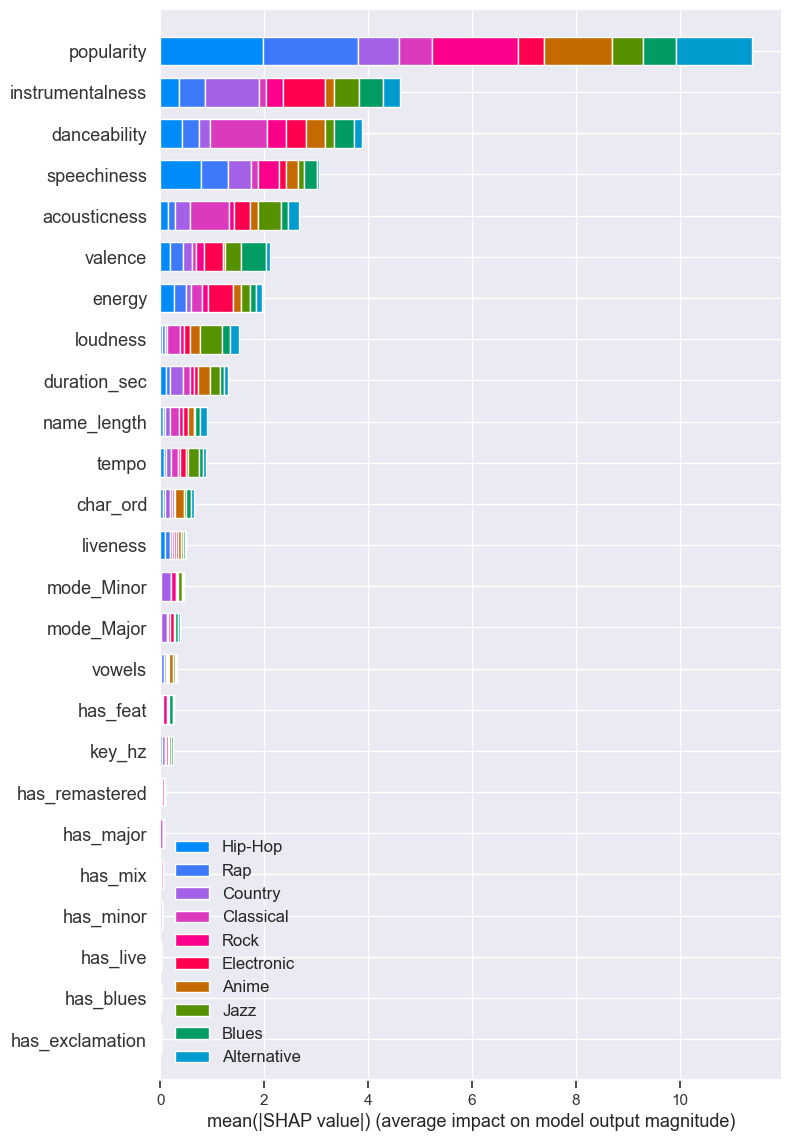

In [180]:
shap_test = shap.TreeExplainer(model).shap_values(df_features_train)
shap.summary_plot(shap_test, df_features_train, max_display=25, class_names=model.classes_)

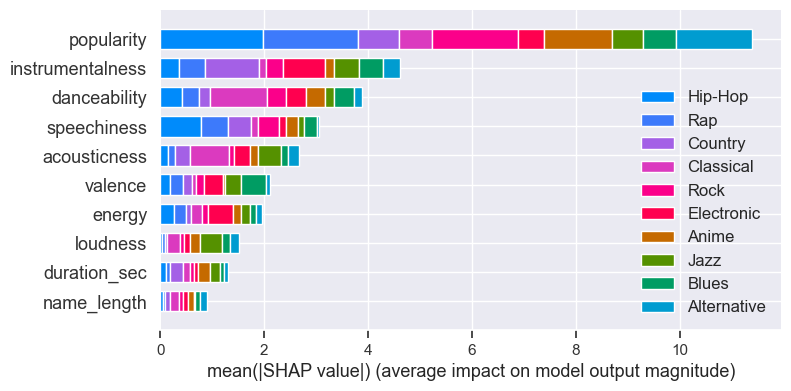

In [185]:
shap.summary_plot(shap_test, df_features_train, max_display=10, class_names=model.classes_, plot_size=[8,4])

### Выводы по разделу

* В пятерку самых значимых признаков для модели вошли: `popularity`, `instrumentalness`, `danceability`, `speechiness`, `acousticness`;

* Среди 20ти самых важных признаков есть те, которые построены на основе названия трека: `name_length` (длина названия трека), `vowels` (доля латинских гласных в названии), `char_ord` (средний код символа в названии), `has_feat` (признак наличия слова feat), `has_remastered` (признак наличия слова remastered);

## Общий вывод

1. Для исследования предоставлены два датасета:

* `train.csv` — информация (40000) музыкальных треках, которые будут использоваться в качестве обучающих данных;
* `test.csv` — информация (10000) музыкальных треках, которые будут использоваться в качестве тестовых данных.

2. Описание полей данных:

* `instance_id` - уникальный идентификатор трека;
* `track_name` - название трека
* `popularity` - популярность трека;
* `acousticness` - мера уверенности от 0,0 до 1,0 в том, что трек является акустическим;
* `danceability` - танцевальность описывает, насколько трек подходит для танцев, основываясь на сочетании музыкальных элементов, включая темп, стабильность ритма, силу ударов и общую регулярность;
* `duration_ms` - продолжительность трека в миллисекундах;
* `energy` - энергия это показатель от 0,0 до 1,0, представляющий собой меру интенсивности и активности;
* `instrumentalness` - определяет, содержит ли трек вокал;
* `key` - базовый ключ произведения;
* `liveness` - определяет присутствие аудитории в записи;
* `loudness` - общая громкость трека в децибелах (дБ);
* `mode` - указывает на модальность трека;
* `speechiness` - речевой характер определяет наличие в треке разговорной речи;
* `tempo` - темп трека в ударах в минуту (BPM);
* `obtained_date` - дата загрузки в сервис;
* `valence` - показатель характеризующий музыкальный позитив, передаваемый треком;
* `music_genre` - музыкальный жанр трека, целевой признак для предсказания.

3. В датасетах отсутствуют явные дубликаты. Столбцы `track_name`, `popularity`, `danceability`, `key`, `mode` и `obtained_date` содержат пропуски. Столбец `tempo` должен быть представлен в числовом формате, однако в исходных данных имеет тип `object`.

4. Проведен исследовательский анализ данных:

* На основе названия трека `track_name` сформировано несколько новых признаков: длина имени, число слов, доля гласных, средний код символа, содержание специальных слов, содержание знака вопроса и знака восклицания;

* Таблица корреляции признаков показывает, что жанр произведения имеет довольно сильную взаимосвязь с `popularity`, `danceability`, `energy`, `instrumentalness`, `loudness`; <br><br> 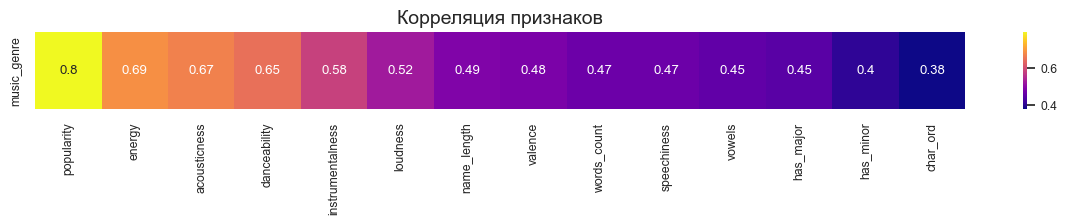

* Пропуски в столбцах `tempo`, `danceability` и `popularity` заполнены с помощью математической модели, которая предсказывает эти признаки на основе других признаков трека. Для регрессии использовался `HistGradientBoostingRegressor`;

* Обнаружены неявные пропуски (значение `-1`) в столбце `duration_ms`. Пропуски заполнены медианным значением столбца. Поскольку точность до миллисекунд скорее всего избыточна, сформирован столбец `duration_sec` с продолжительностью трека в секундах;

* Пропуски в столбцах `mode` и `key` заполнены значением `Undefined`;

* На основе столбца `key` сформирован новый столбец `key_hz`, который содержит частоту соответствующей ноты. Пропущенные ноты из столбца `key` заполнены медианным значением `key_hz`;

* Столбцы `obtained_date` и `instance_id` не несут полезной информации для обучения модели;

* Столбец `popularity` возможно содержит в себе утечку целевого признака. Например, треки в жанре поп-музыки будут заведомо иметь большую популярность чем классическая музыка. Кроме того, в момент загрузки нового произведения его популярность еще не известна;

* Наибольшей популярностью в датасете пользуются жанры `Rap` и `Rock`, а наименьшей `Anime` и `Classical`;

* Дисбаланс классов целевого признака отсутствует.

5. Подготовлены датасеты для обучения и тестирования модели:
* Признаки `instance_id`, и `obtained_date` исключены из обучения модели, т.к. не имеют предсказательной силы;

* Вместо признака `duration_ms` для обучения используется `duration_sec`, а вместо признака `key` его количественный аналог `key_hz`;

* Для признака `mode` применено `OHE` кодирование;

* Масштабирование признаков с помощью `StandartScaler` применено для `popularity`, `acousticness`, `danceability`, `energy`, `instrumentalness`, `liveness`, `loudness`, `speechiness`, `tempo`, `valence`, `duration_sec`, `name_length`, `key_hz`;

* Итоговый датасет для обучения имеет 40.000 наблюдений из 30 признаков и одного целевого признака `music_genre`. Датасет для тестирования имеет 10.000 наблюдений из 30 признаков.

6. Выполнен поиск лучшей модели:
* Для решения задачи мультиклассификации использовались следующие классификаторы: `DecisionTreeClassifier`, `RandomForestClassifier`, `GradientBoostingClassifier` и `VotingClassifier`, состоящий из ансамбля `трех HistGradientBoostingClassifier`;

* Для обучения и подбора гипер-параметров моделей использовался `GridSearchCV` с разбивкой на 5 кроссвалидационных выборок;

* В качестве целевой метрики для оптимизации использовалась `F1-Micro`;

* Наилучшее значенние целевой метрики достигнуто с помощью ансамбля из трех `HistGradientBoostingClassifier`;

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe" style="margin-left:40px">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Классификатор</th>
      <th>F1 Micro</th>
      <th>Стандартное отклонение</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>3</th>
      <td>HistGradientBoostingClassifier (3x Voting)</td>
      <td>0.5844</td>
      <td>0.0049</td>
    </tr>
    <tr>
      <th>1</th>
      <td>RandomForestClassifier</td>
      <td>0.5499</td>
      <td>0.0043</td>
    </tr>
    <tr>
      <th>2</th>
      <td>GradientBoostingClassifier</td>
      <td>0.5273</td>
      <td>0.0054</td>
    </tr>
    <tr>
      <th>0</th>
      <td>DecisionTreeClassifier</td>
      <td>0.5021</td>
      <td>0.0044</td>
    </tr>
  </tbody>
</table>
</div>

7. Исследована важность признаков:

* В пятерку самых значимых признаков для модели вошли: `popularity`, `instrumentalness`, `danceability`, `speechiness`, `acousticness`;

* Среди 20ти самых важных признаков есть те, которые построены на основе названия трека: `name_length` (длина названия трека), `vowels` (доля латинских гласных в названии), `char_ord` (средний код символа в названии), `has_feat` (признак наличия слова feat), `has_remastered` (признак наличия слова remastered); <br><br> 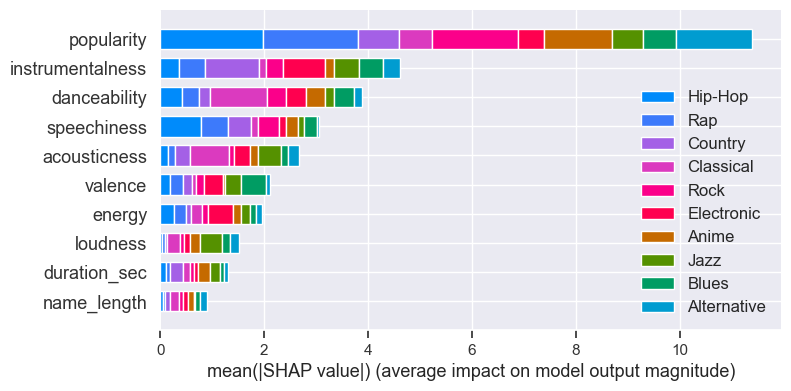

8. Выполнена проверка работы модели на тестовом датасете: 

* На тестовом датасете лучшая модель показала значение `0.58380` метрики F1-Micro.